# 02477 Bayesian Machine Learning - Exercise 4

In [1]:
%matplotlib inline
import jax.numpy as jnp
import jax
import numpy as onp
from jax import random
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as snb

from scipy.optimize import minimize

from scipy.stats import multivariate_normal as mvn
from scipy.stats import beta as beta_dist
from scipy.stats import binom as binom_dist
from scipy.stats import norm as norm_dist

from mpl_toolkits.axes_grid1 import make_axes_locatable

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.)

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

jax.config.update("jax_enable_x64", True)

# Introduction

In this exercise, we will work with probabilistic methods for classification. We will focus on **binary** classification, but everything we discuss can fairly easily be extended to **multi-class** classification. For binary classification we typically observe a dataset $\mathcal{D} = \left\lbrace (\mathbf{x}_n, y_n) \right\rbrace_{n=1}^N$, where $\mathbf{x}_n \in \mathbb{R}^D$ and $y_n \in \left\lbrace 0, 1 \right\rbrace$ are assumed to be input features and label for the $n$'th observation, respectively. Our goal is to use the dataset $\mathcal{D}$ to reason about a new data point $\mathbf{x}^* \in \mathbb{R}^D$ and its associated label $y^* \in \left\lbrace 0, 1\right\rbrace$.

We will study two different approaches: the **generative** and the **discriminative** approach. In the former we model the **joint distribution of inputs and outputs**, i.e. $p(\mathbf{x}, y)$, whereas in the latter we only model the **conditional distribution of the output conditioned on the input**, i.e. $p(y|\mathbf{x})$. That is, for generative classification we make assumptions on the distribution of the inputs $p(\mathbf{x})$, either implicitly or explicitly, whereas for discriminative classification we only make assumptions about the distribution of the different outcomes given the specific input. 

We will also study the Laplace approximation as a computational tool for approximating the posterior distribution of the parameters of a probabilistic model. First, we will study the properties of the Laplace approximation using a model we also know, the beta-binomial model. Afterwards, we will apply the Laplace approximation to the logistic regression model.


**Content**

- Part 1: Implementing a simple generative classifier
- Part 2: Understanding the Laplace approximations
- Part 3: Implementing the logistic regression model
- Part 4: Implementing the Laplace approximation for logistic regression
- Part 5: Approximating the posterior predictive distribution
- Part 6: Insights into the posterior predictive distribution via the probit approximation


We will be working with the MNIST dataset (more information here: http://yann.lecun.com/exdb/mnist/), which consists of digital images of digits from 0-9. Each image is 28x28 pixels and is represented in a vectorized manner such that each image is represented as a vector in $\mathbb{R}^{784}$. Specifically, we will build classifiers for distinguishing between 8s (encoded as $y=0$) and 9s (encoded as $y=1$), a binary classification problem. In order to visualize the resulting dataset, we use **principal component analysis** (PCA) to reduce the dimensionality to $D = 2$. We won't cover PCA in this course, but you can read more about it in Section 20.1 in Murphy1 or in Section 12.1 in the Bishop if you are unfamiliar with it.

The matrices $\textbf{I}_{\text{train}} \in \mathbb{R}^{197 \times 784}$ and $\textbf{X}_{\text{train}} \in \mathbb{R}^{197 \times 2}$ contains the raw pixel values and the low-dimensional PCA representation, respectively. Note that we will use a fairly small training set to make the problem more challenging.
_____________________

Shape of Itrain: (197, 784)
Shape of Xtrain: (197, 2)
Shape of ytrain: (197,)


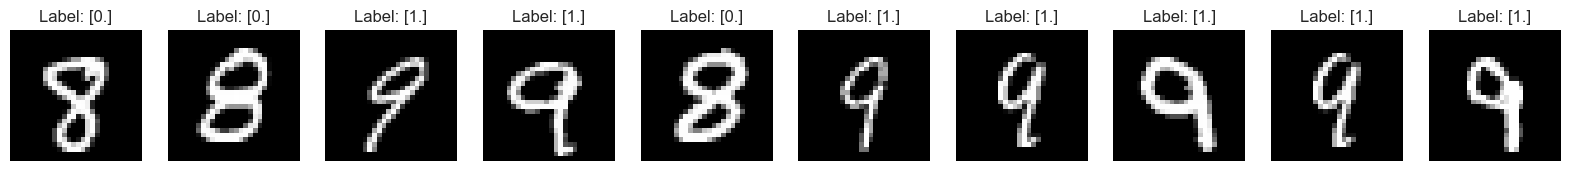

In [2]:
# read data
data = jnp.load('../mnist_subset_89.npz')
Itrain, Itest  = data['Itrain'], data['Itest']
Xtrain, Xtest = data['Xtrain'], data['Xtest']
ytrain, ytest = data['ytrain'], data['ytest']
digits = data['digits']

key = random.PRNGKey(1)
fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for idx_plot, i in enumerate(random.choice(key, jnp.arange(len(Xtrain)), shape=(10, 1))):
    ax[idx_plot].imshow(Itrain[i].reshape((28, 28)), cmap=plt.cm.gray)
    ax[idx_plot].set_title(f'Label: {ytrain[i]}') 
    ax[idx_plot].axis('off')

# print shapes of Images (Itrain), feature representations (Xtrain) and labels (ytrain)
print('Shape of Itrain:', Itrain.shape)
print('Shape of Xtrain:', Xtrain.shape)
print('Shape of ytrain:', ytrain.shape)

We will work in the 2-dimensional PCA space in the rest of the exercise for easier visualization, but nothing prevents us from working on the original data space. 

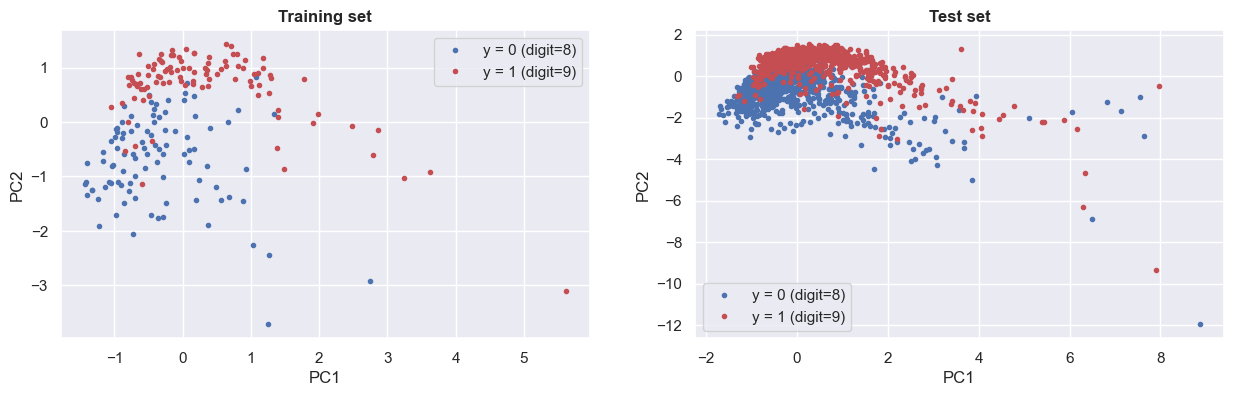

In [3]:
def plot_data(ax, X, y, alpha=0.8, title=None):
    """
    Plots 2D data points colored by class label.

    Parameters:
        ax: matplotlib Axes object to plot on.
        X: array-like, shape (N, 2)
            2D feature matrix (e.g., PCA-reduced MNIST data).
        y: array-like, shape (N,)
            Binary class labels (0 or 1).
        alpha: float, optional
            Transparency for the points.
        title: str, optional
            Title for the plot.

    Output:
        The function plots the data on the given axes, with different colors for each class.
    """

    ax.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], 'b.', label='y = 0 (digit=8)')
    ax.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], 'r.', label='y = 1 (digit=9)')
    ax.set(xlabel='PC1', ylabel='PC2')
    ax.legend()
    

    if title:
        ax.set_title(title, fontweight='bold')        

# Example usage:
# Xtrain: shape (197, 2), ytrain: shape (197,)
# Xtest: shape (1781, 2), ytest: shape (1781,)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
plot_data(ax[0], Xtrain, ytrain, title='Training set')
plot_data(ax[1], Xtest, ytest, title='Test set')

# Part 1:  Implementing a simple generative classifier

In the first part of the exercise, we will study a simple **generative classifier** given by

$$\begin{align*}
p(y = k | \textbf{x}) = \frac{p(\textbf{x}|y=k)p(y=k)}{p(\textbf{x})},
\end{align*}$$

where
- $k$ can take the values $0$ or $1$ since we are dealing with binary classification
- $p(y = k | \textbf{x})$ the posterior probability that the observation $y$ belongs to class $k$ given the input point $\textbf{x}$
- $p(\textbf{x}|y=k)$ is the class-conditional distribution for class $k$
- $p(y=k)$ is the prior class probability for the $k$'th class
- $p(\textbf{x})$ is the marginal density of the data

The **prior probability**, $p(y=k)$ of an observation belonging to class $k$ is given by $p(y=k)=\pi_k \in \left[0,1\right]$ and satisfies $\sum_{k} \pi_k = 1$.

For the **class-conditional distributions** we will **assume** bivariate normal distributions with mean $\mathbf{m}_k$ and covariance matrix $\textbf{S}_k$. That is,
\begin{align*}
p(\textbf{x}|y=k) = \mathcal{N}(\textbf{x}_n|\mathbf{m}_k, \textbf{S}_k).
\end{align*}

We can derive the marginal data distribution $p(\textbf{x})$ via the sum rule by marginalizing out $y$ from $p(\textbf{x}, y)$:

$$
\begin{align*}
p(\textbf{x}) = \sum_{y} p(\textbf{x}, y) = \sum_{y} p(\textbf{x}|y)p(y) =p(y=0)\mathcal{N}(\textbf{x}|\mathbf{m}_0, \textbf{S}_0) + p(y=1)\mathcal{N}(\textbf{x}|\mathbf{m}_1, \textbf{S}_1).
\end{align*}
$$


We can estimate this probability using the training data by estimating the fraction data point belong to each of the classes, e.g.

$$\begin{align*}
\pi_1 = p(y=1) &\approx \frac{\text{number of training point with label 1}}{\text{total number of training points}} = \frac{1}{N} \sum_{n=1}^N y_n.
\end{align*}
$$

We only need to estimate the prior probability for one of the two classes since $p(y=0) = 1 - p(y=1)$.

The posterior distribution $p(y|\textbf{x})$ gives us a number in the unit interval. We can turn this into a classification rule, by classifying an input point $x$ as the class $k$ that maximizes the posterior class probability. That is,

$$
\begin{align*}
\hat{y}_n = \arg\max\limits_{k} p(y_n = k | x_n)
\end{align*}
$$



First, we estimate the prior probability of $p(y=1)$ and $p(y=0)$ using the training data:

In [4]:
# Let ytrain be our training labels, an array of shape (N_train,)
# where each y_n ∈ {0,1}.  We want to estimate the class‐priors:
#   π₁ = p(y=1)   and   π₀ = p(y=0) = 1 − π₁.

# Number of training examples:
N_train = ytrain.shape[0]                # shape: () scalar

# Estimate π₁ by the fraction of labels equal to 1.
# Equation: π₁ ≈ (1/N) ∑_{n=1}^N y_n
pi1 = jnp.mean(ytrain)                   # shape: () scalar

# The other class prior π₀ follows from normalization:
# Equation: π₀ = 1 − π₁
pi0 = 1.0 - pi1                          # shape: () scalar

# Print the estimated priors
print(f'p(y = 1) = {pi1:4.3f}')          # e.g. p(y=1)=0.235
print(f'p(y = 0) = {pi0:4.3f}')          # e.g. p(y=0)=0.765


p(y = 1) = 0.513
p(y = 0) = 0.487


Next, we estimate and report the parameters of the class-conditional distributions $p(\mathbf{x}|y=k)$, i.e. $\left\lbrace \textbf{m}_0, \textbf{m}_1, \textbf{S}_0, \textbf{S}_1 \right\rbrace$, using the training data


In [5]:
# Assume:
#   Xtrain : array of shape (N, D)
#            -- each row is a D-dimensional feature vector xₙ
#   ytrain : array of shape (N,) with values in {0,1}
#            -- each entry yₙ is the class label for Xtrain[n]

# 1) Select only those rows of Xtrain for which ytrain == 0
#    Let N₀ = number of examples with class 0
X0 = Xtrain[ytrain.ravel() == 0, :]     # shape: (N₀, D)

# 2) Empirical class-conditional mean for class 0:
#    m₀ = (1/N₀) ∑_{n: yₙ=0} xₙ
m0 = jnp.mean(X0, axis=0)               # shape: (D,)

# 3) Empirical class-conditional covariance for class 0:
#    S₀ = (1/(N₀−1)) ∑_{n: yₙ=0} (xₙ − m₀)(xₙ − m₀)ᵀ
#    jnp.cov by default uses the unbiased estimator (divide by N₀−1)
S0 = jnp.cov(X0.T)                      # shape: (D, D)


# Repeat for class 1:

# 4) Select Xtrain rows where ytrain == 1
#    Let N₁ = number of examples with class 1
X1 = Xtrain[ytrain.ravel() == 1, :]     # shape: (N₁, D)

# 5) Empirical mean m₁ = (1/N₁) ∑_{n: yₙ=1} xₙ
m1 = jnp.mean(X1, axis=0)               # shape: (D,)

# 6) Empirical covariance S₁ = (1/(N₁−1)) ∑_{n: yₙ=1} (xₙ − m₁)(xₙ − m₁)ᵀ
S1 = jnp.cov(X1.T)                      # shape: (D, D)


# 7) Print the results with two decimal precision
print('Estimated class-conditional parameters for p(x|y=0):\n')
print('  Mean vector m₀:')
print(onp.array2string(m0, precision=2), '\n')
print('  Covariance matrix S₀:')
print(onp.array2string(S0, precision=2), '\n\n')

print('Estimated class-conditional parameters for p(x|y=1):\n')
print('  Mean vector m₁:')
print(onp.array2string(m1, precision=2), '\n')
print('  Covariance matrix S₁:')
print(onp.array2string(S1, precision=2))


Estimated class-conditional parameters for p(x|y=0):

  Mean vector m₀:
[-0.36 -0.69] 

  Covariance matrix S₀:
[[ 0.56 -0.09]
 [-0.09  0.66]] 


Estimated class-conditional parameters for p(x|y=1):

  Mean vector m₁:
[0.34 0.66] 

  Covariance matrix S₁:
[[ 1.19 -0.39]
 [-0.39  0.45]]


We can plot the contours of the two class-conditional distributions superimposed the training data.


In [6]:
def eval_density_grid(density_fun, dim1_array, dim2_array):
    """
    Evaluate a 2D density function on a grid of input points.

    This routine constructs a meshgrid from two 1D coordinate arrays,
    stacks the grid points into a (M*N, 2) array, calls `density_fun` on
    all points at once, and reshapes the output back to an (M, N) grid.

    Args:
        density_fun: Callable[[jnp.ndarray], jnp.ndarray]
            A function that takes an array of shape (P, 2) and returns
            the log-density or density values at those P points as a flat array
            of shape (P,) or (P, 1).

        dim1_array: jnp.ndarray of shape (M,)
            1D array of coordinate values along the first axis (e.g. alpha grid).

        dim2_array: jnp.ndarray of shape (N,)
            1D array of coordinate values along the second axis (e.g. beta grid).

    Returns:
        grid_vals: jnp.ndarray of shape (M, N)
            The evaluated density_fun on each grid point.  Specifically,
            grid_vals[i, j] = density_fun([dim1_array[i], dim2_array[j]]).

    Equations:
        Let (x_i)_{i=1}^M = dim1_array, (y_j)_{j=1}^N = dim2_array.
        Then we build all pairs (x_i, y_j) for i=1..M, j=1..N.
        If P = M*N, arrange them in XX of shape (P,2):
            XX[k] = [x_i, y_j],  k = (i-1)*N + j.
        Finally compute:
            values = density_fun(XX)  # shape (P,)
        and reshape:
            grid_vals = values.reshape(M, N).
    How to use:
        grid_vals = eval_density_grid(density_fun, alpha_grid, beta_grid)
        # where density_fun is a function that takes (P, 2) and returns (P,)
        
    """
    # Create two 2D arrays of shape (M, N) each, such that:
    #   X1[i, j] = dim1_array[i]
    #   X2[i, j] = dim2_array[j]
    # 'indexing="ij"' means the first dimension corresponds to dim1_array.
    X1, X2 = jnp.meshgrid(dim1_array, dim2_array, indexing='ij')

    # Flatten the grid arrays to 1D of length P = M*N, then column-stack
    # so that XX has shape (P, 2): each row is one (dim1, dim2) pair.
    XX = jnp.column_stack((X1.ravel(), X2.ravel()))
    # Call the density function once on all P points.  Expect an output
    # of shape (P,) (or (P, 1)).
    vals = density_fun(XX)

    # Reshape the flat results back into the grid shape (M, N)
    M = len(dim1_array)
    N = len(dim2_array)
    return vals.reshape((M, N))


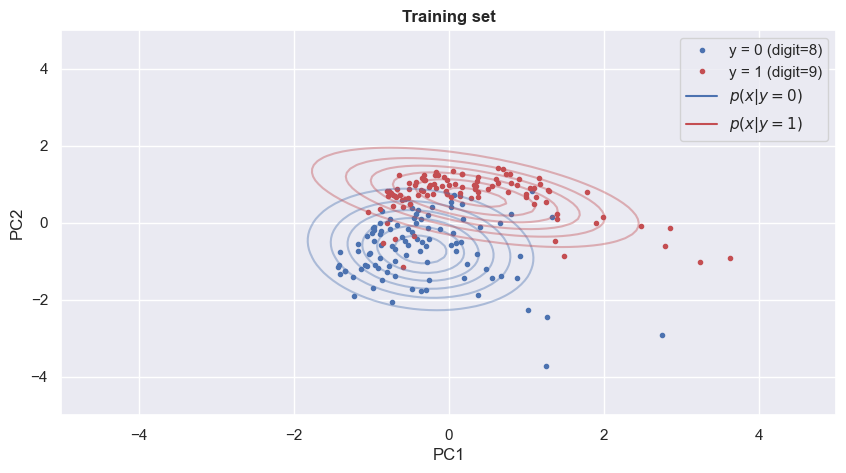

In [7]:
def plot_distribution(ax, dim1_array, dim2_array,
                      density_fun,
                      color=None,
                      alpha=1,
                      label=None,
                      title=None,
                      num_points=100):
    """
    Plot a 2D density function as contour lines on the given axes.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes on which to draw the contour plot.

    dim1_array : array-like, shape (I,)
        1-D array of values for the first dimension (e.g., alpha values).

    dim2_array : array-like, shape (J,)
        1-D array of values for the second dimension (e.g., beta values).

    density_fun : callable
        Function that accepts an array of shape (M, 2) and returns
        an array of shape (M,) containing log-density values:

            f_vals = density_fun(XY)
            where XY[k] = [dim1_i, dim2_j]
            and f_vals[k] = log p(x|y) or log p(w|D), etc.

    color : color specifier, optional
        Line color for contours.

    alpha : float, optional
        Transparency for contour lines.

    label : str, optional
        Legend label to add for this distribution.

    title : str, optional
        Title for the axes (ax.set_title).

    num_points : int, unused here (legacy).

    Returns:
    --------
    None

    Outputs:
    --------
    - Plots contour lines of exp(log-density) on ax.
    - Adds a dummy out-of-bounds line to register the label if provided.

    Steps:
    ------
    1. Compute Z_log = density_fun on grid of shape (I, J):
         Z_log[i, j] = density_fun([dim1_array[i], dim2_array[j]])
       using helper eval_density_grid.

    2. Exponentiate to get actual density:
         Z[i, j] = exp(Z_log[i, j])

    3. Call ax.contour(x=dim1_array,
                      y=dim2_array,
                      Z.T,
                      colors=color,
                      alpha=alpha)
       Note the transpose so that dims align.

    4. If `label` is given, plot an off-screen dummy line with that label to
       include in the legend.

    Equations:
    ----------
    # Grid evaluation:
    \[ Z_{ij} = \exp\Bigl(density\_fun([\alpha_i,\beta_j])\Bigr) \]

    # Contour plotting:
    contour(dim1_array, dim2_array, Z^T)

    Usage example:
    --------------
    # Define grid
    alphas = jnp.linspace(-5,5,100)
    betas  = jnp.linspace(-5,5,101)

    # Define log-density functions
    log_p_x_given_y0 = lambda x: mvn.logpdf(x, m0, S0)
    log_p_x_given_y1 = lambda x: mvn.logpdf(x, m1, S1)

    # Plot
    fig, ax = plt.subplots(figsize=(6,6))
    plot_distribution(ax, alphas, betas,
                      log_p_x_given_y0,
                      color='b', alpha=0.5,
                      label='$p(x|y=0)$')
    plot_distribution(ax, alphas, betas,
                      log_p_x_given_y1,
                      color='r', alpha=0.5,
                      label='$p(x|y=1)$')
    ax.legend()
    ax.set_title('Class-conditional distributions')
    plt.show()
    """
    # 1) evaluate log-density on grid
    Z = eval_density_grid(density_fun, dim1_array, dim2_array)
    # 2) exponentiate to obtain density
    #    and transpose so (i,j)->(j,i) aligns x-y axes
    cs = ax.contour(dim1_array,
                    dim2_array,
                    jnp.exp(Z).T,
                    colors=color,
                    alpha=alpha)
    # 3) dummy plot for legend
    if label:
        ax.plot([-1000], [-1000], color=color, label=label)
    # 4) set plotting limits and title
    ax.set(xlim=(dim1_array[0], dim1_array[-1]),
           ylim=(dim2_array[0], dim2_array[-1]))
    if title:
        ax.set_title(title)



# specify grids for plotting (I usually different different number of points in each dimension to make debugging easier)
dim1_array = jnp.linspace(-5, 5, 100)           # shapes (100,)             
dim2_array = jnp.linspace(-5, 5, 101)           # shapes (100,)

# define function evaluating  class-conditionals
log_p_x_given_y0 = lambda x: mvn.logpdf(x, m0, S0)   # shape (D,)   
log_p_x_given_y1 = lambda x: mvn.logpdf(x, m1, S1)   # shape (D,)  

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_data(ax, Xtrain, ytrain, title='Training set')
plot_distribution(ax, dim1_array, dim2_array, log_p_x_given_y0, color='b', alpha=0.4, label='$p(x|y=0)$')
plot_distribution(ax, dim1_array, dim2_array, log_p_x_given_y1, color='r', alpha=0.4, label='$p(x|y=1)$')
ax.legend();

**Task 1.1**: Implement a function for evaluating the posterior distribution $p(y=1|\textbf{x})$ and the marginal data distribution $p(\textbf{x})$

**Solution**


In [8]:
# Functions to compute marginal and posterior probabilities for binary classes
# ---------------------------------------------------------------
# Input shapes:
#   x       : array of shape (M, D) or (D,) representing M points in D dimensions
#            or a single point of shape (D,) which will be broadcast to (1, D)
# Output shapes:
#   p_x_given_y* : array of shape (M,) giving class-conditional density at each point
#   marginal     : array of shape (M,) giving p(x) at each point
#   log_marginal : array of shape (M,) giving log p(x) at each point
#   posterior_y1 : array of shape (M,) giving p(y=1|x) at each point

# Class-conditional densities:
#   p(x|y=0) = N(x | m0, S0)
#   p(x|y=1) = N(x | m1, S1)
p_x_given_y0 = lambda x: mvn.pdf(x, m0, S0)
# Equation: p(x|y=0) = (2π)^(-D/2) |S0|^(-1/2) exp(-1/2 (x-m0)^T S0^{-1} (x-m0))

p_x_given_y1 = lambda x: mvn.pdf(x, m1, S1)
# Equation: p(x|y=1) = N(x|m1,S1) analogous to above

# Marginal data density (total probability over classes):
#   p(x) = π0 p(x|y=0) + π1 p(x|y=1)
marginal = lambda x: pi0 * p_x_given_y0(x) + pi1 * p_x_given_y1(x)
# Equation: p(x) = ∑_k π_k p(x|y=k)

# Logarithm of marginal density, useful for numeric stability:
#   log p(x) = log( p(x) )
log_marginal = lambda x: jnp.log(marginal(x))

# Posterior probability of class 1 given x by Bayes' rule:
#   p(y=1|x) = π1 p(x|y=1) / p(x)
posterior_y1 = lambda x: (pi1 * p_x_given_y1(x)) / marginal(x)

# Usage example:
#   pts = jnp.array([[x1, x2], [x3, x4], ...])  # shape (M,2)
#   p0 = p_x_given_y0(pts)        # shape (M,)
#   p1 = p_x_given_y1(pts)        # shape (M,)
#   pm = marginal(pts)            # shape (M,)
#   lp = log_marginal(pts)        # shape (M,)
#   post1 = posterior_y1(pts)     # shape (M,)


**End of solution**

**Task 1.2**: Create a plot with three subfigures: 1) plotting the class-conditional data distributions superimposed on the data, 2) plot the marginal data distribution superimposed on the data, and 3) plot the posterior distribution superimposed on the data. Comment on the plots.

**Solution**

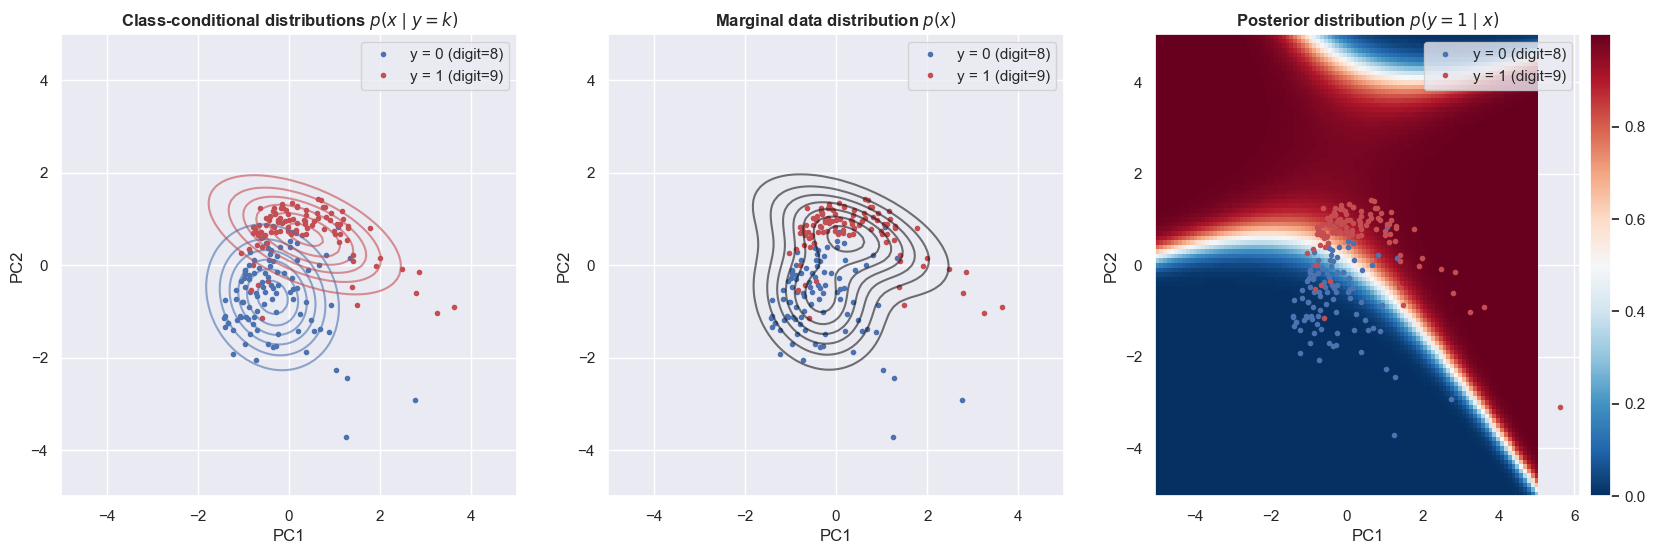

In [9]:
# 1) Evaluate posterior p(y=1 | x) on a 2D grid
#    We already have:
#      posterior_y1: function mapping (M,2) array -> (M,) array of p(y=1|x) values
#      dim1_array:   1D array of length I (e.g. alpha axis or feature1 values)
#      dim2_array:   1D array of length J (e.g. beta axis or feature2 values)
#    We form an (I x J) grid of posterior values:
post_grid = eval_density_grid(posterior_y1, dim1_array, dim2_array)
# post_grid.shape == (I, J)

# 2) Prepare a 1x3 figure for side-by-side visualization
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# 3) Column 1: plot raw training data on top of axes[0..2]
#    plot_data overlays Xtrain vs ytrain scatter
for i in range(3):
    plot_data(ax[i], Xtrain, ytrain, title='Training set')

# 4) Column 1 continuation: class-conditional contours
#    p(x|y=0) in blue, p(x|y=1) in red
plot_distribution(
    ax[0], dim1_array, dim2_array,
    log_p_x_given_y0,
    color='b', alpha=0.6,
    label='$p(x\mid y=0)$'
)
plot_distribution(
    ax[0], dim1_array, dim2_array,
    log_p_x_given_y1,
    color='r', alpha=0.6,
    label='$p(x\mid y=1)$'
)
ax[0].set_title('Class-conditional distributions $p(x\mid y=k)$', fontweight='bold')
# Eqns: p(x) = π_0 N(x|m0,S0) + π_1 N(x|m1,S1)

# 5) Column 2: marginal data distribution p(x) contours
#    log_marginal(x) = log( π0 p(x|0) + π1 p(x|1) )
plot_distribution(
    ax[1], dim1_array, dim2_array,
    log_marginal,
    color='k', alpha=0.6,
    label='$p(x)$'
)
ax[1].set_title('Marginal data distribution $p(x)$', fontweight='bold')

# 6) Column 3: posterior probability p(y=1|x)
#    We have post_grid[i,j] = p(y=1 | x=[dim1[i],dim2[j]])
im = ax[2].pcolormesh(
    dim1_array, dim2_array,
    post_grid.T,
    cmap=plt.cm.RdBu_r,
    shading='auto'
)
ax[2].set_title('Posterior distribution $p(y=1\mid x)$', fontweight='bold')
# Eqn: p(y=1|x) = π1 p(x|1) / [π0 p(x|0) + π1 p(x|1)]

# 7) Add colorbar for the pcolormesh in column 3
def add_colorbar(im, fig, ax):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax)

add_colorbar(im, fig, ax[2])

# Usage:
#  - Ensure that Xtrain (N,D), ytrain (N,) are loaded.
#  - Define dim1_array and dim2_array as 1D grids covering your feature space.
#  - Define log_p_x_given_y0, log_p_x_given_y1, posterior_y1 as above.
#  - Call this block to visualize all three distributions side-by-side.


**End of solution**

We will use the **accuracy** and **ELPD** (expected log predictive density) to quantify the performance of the classifier is given by

$$
\begin{align}
\text{ELPD}(\textbf{y}^*, \textbf{p}^*) = \frac{1}{M} \sum_{i=1}^M \log \left(\text{Ber}(y^*_i|p^*_i)\right),
\end{align}
$$

where $\textbf{y}^*$ in this case is the vector of ground truth values and $\textbf{p} ^*$ is a vector of predictive probabilities, i.e. $p^*_i = p(y^*_i=1|\textbf{x}^*_i)$. Accuracy only measures how often we are correct and incorrect, whereas the ELPD also takes in uncertainty into account. For both metrics, larger values are better.


In [10]:
# Function for evaluating accuracy
def accuracy(y_true, p_hat, threshold=0.5):
    """
    Compute classification accuracy.
    
    Equation:
        accuracy = (1/n) * Σ[i=1 to n] I(y_true[i] == ŷ[i])
    where:
        ŷ[i] = 1 if p_hat[i] > threshold, else 0
        I(·) is the indicator function
    
    Args:
        y_true: array-like, shape (n,) or (n, 1)
            True binary labels (0 or 1)
        p_hat: array-like, shape (n,) or (n, 1)
            Predicted probabilities in [0, 1]
        threshold: float, default=0.5
            Decision threshold for converting probabilities to binary predictions
    
    Returns:
        float: Accuracy score in [0, 1]
    """
    # Convert to 1D arrays and compute binary predictions
    y_pred = 1.0 * (p_hat.ravel() > threshold)
    
    # Compare predictions with true labels
    return jnp.mean(y_true.ravel() == y_pred)


# Function for evaluating the ELPD (Expected Log Predictive Density)
def elpd(y_true, p_hat):
    """
    Compute Expected Log Predictive Density for binary classification.
    
    Equation:
        ELPD = (1/n) * Σ[i=1 to n] log P(y_true[i] | p_hat[i])
    
    For binary classification with Bernoulli distribution:
        P(y | p) = p^y * (1-p)^(1-y)
        log P(y | p) = y * log(p) + (1-y) * log(1-p)
    
    Args:
        y_true: array-like, shape (n,) or (n, 1)
            True binary labels (0 or 1)
        p_hat: array-like, shape (n,) or (n, 1)
            Predicted probabilities in [0, 1]
    
    Returns:
        float: ELPD score (negative value, higher is better)
    
    Notes:
        - ELPD measures how well the predicted probabilities match the true distribution
        - Unlike accuracy, ELPD considers the confidence of predictions
        - More negative values indicate worse predictive performance
    """
    # Flatten arrays to ensure 1D shape
    y_flat = y_true.ravel()
    p_flat = p_hat.ravel()
    
    # Compute log probability for each observation using Bernoulli distribution
    log_probs = binom_dist.logpmf(y_flat, n=1, p=p_flat)
    
    # Return average log probability
    return jnp.mean(log_probs)


# Example demonstrating the difference between accuracy and ELPD
y_example = jnp.array([1, 1, 0, 0, 0])  # True labels: 2 positives, 3 negatives

# Model 1: Very confident predictions (close to 0 or 1)
p_example1 = jnp.array([0.95, 0.95, 0.95, 0.95, 0.1])
# Predicted: [1, 1, 1, 1, 0] → 1 error (overconfident on index 2 and 3)

# Model 2: Less confident but more accurate predictions  
p_example2 = jnp.array([0.95, 0.95, 0.51, 0.51, 0.1])
# Predicted: [1, 1, 1, 1, 0] → 3 errors (barely wrong on index 2 and 3)

print("Performance Comparison:")
print("-" * 30)
print(f' Acc(y, p1) =  {accuracy(y_example, p_example1):3.2f}')
print(f' Acc(y, p2) =  {accuracy(y_example, p_example2):3.2f}')
print(f'ELPD(y, p1) = {elpd(y_example, p_example1):3.2f}')
print(f'ELPD(y, p2) = {elpd(y_example, p_example2):3.2f}')

# Additional insights
print("\nInsights:")
print("- Both models have the same accuracy (0.60)")
print("- Model 1 is overconfident on wrong predictions → worse ELPD")
print("- Model 2 is less confident on wrong predictions → better ELPD")
print("- ELPD penalizes confident wrong predictions more heavily")

Performance Comparison:
------------------------------
 Acc(y, p1) =  0.60
 Acc(y, p2) =  0.60
ELPD(y, p1) = -1.24
ELPD(y, p2) = -0.33

Insights:
- Both models have the same accuracy (0.60)
- Model 1 is overconfident on wrong predictions → worse ELPD
- Model 2 is less confident on wrong predictions → better ELPD
- ELPD penalizes confident wrong predictions more heavily


We can now evaluate the accuracy and ELPD for the training set and test set:

In [11]:
# Dictionary of evaluation metrics
metrics = {'Accuracy': accuracy, 'ELPD': elpd}

# Compute posterior probabilities P(y=1|X) for training and test sets
# Equation: p̂ = P(y=1|X) = posterior_y1(X)
p_train_hat = posterior_y1(Xtrain)  # Shape: (n_train,)
p_test_hat = posterior_y1(Xtest)    # Shape: (n_test,)

# Display performance metrics
print(40*'*')
print(f'Metric\t\tTraining\tTest')
print(40*'*')
# For each metric, evaluate on both train and test sets
for metric_name, metric_fun in metrics.items():
    # Equation: metric(y_true, p_hat)
    # Training: evaluate how well model fits training data
    # Test: evaluate generalization to unseen data
    print(f'{metric_name:15s}\t{metric_fun(ytrain, p_train_hat):+3.2f}\t\t{metric_fun(ytest, p_test_hat):+3.2f}')

****************************************
Metric		Training	Test
****************************************
Accuracy       	+0.89		+0.90
ELPD           	-0.31		-0.40


The concludes the part on **generative modelling**.

# Part 2:  Understanding the Laplace approximations

Before we can study the **discriminative approach** for classification, we first need to study the **Laplace approximation** because this will be our main workhorse for (approximate) posterior inference. To gain some intuition, we will first study the Laplace approximation in the context of a model we already now and understand, the Beta-binomial model, which is given by

$$\begin{align*}
y|\theta &\sim \text{Bin}(N, \theta),\\
\theta &\sim \text{Beta}(\alpha_0, \beta_0)
\end{align*}
$$

with joint distribution $p(y, \theta) = p(y|\theta)p(\theta)$ and $\alpha_0, \beta_0 > 0$ are fixed hyperparameters. For this specific model, we already know that the true posterior of $\theta$ is another Beta distribution given by

$$\begin{align*}
p(\theta|y) = \text{Beta}(\theta|\alpha_0 + y, \beta_0 + N -y).
\end{align*}$$

Hence, we can approximate $p(\theta|y)$ with a Laplace approximation $q(\theta) = \mathcal{N}(\theta|\textbf{m}, \textbf{V})$ and the study the accuracy of the $q(\theta)$ by comparing it to the true solution $p(\theta|y)$.
Recall, the Laplace approximation is obtained by making a second order Taylor approximation of the log joint distribution, i.e. $f(\theta) = \log p(\theta, y)$, around the mode, i.e. $\theta_{\text{MAP}} = \arg\max_{\theta} p(\theta|y)$:

$$\begin{align*}
f(\theta) \approx f(\theta_{\text{MAP}}) - \frac{1}{2}(\theta-\theta_{\text{MAP}})A(\theta - \theta_{\text{MAP}})
\end{align*}
$$

leading to the Laplace approximation

$$\begin{align*}
p(\theta|y) \approx q(\theta) = \mathcal{N}(\theta|\theta_{\text{MAP}}, A^{-1}),
\end{align*}$$

where $A$ is the negative second order derivative of $f(\theta)$.

Hence, to set-up the Laplace approximation, our first order of business is to get a handle on the joint distribution:

$$\begin{align*}
p(y, \theta) = p(y|\theta)p(\theta).
\end{align*}$$



____________________________________________________

**Task 2.1**: Show that the log joint distribution is given by $\ln p(y, \theta) = (\alpha_0 + y - 1)  \ln \theta +  (\beta_0 + N-y -1)\ln (1-\theta) + \text{constant}$

**Solution**


Inserting the expression for the binomial distribution and the beta distribution and simplifying yields the desired result

$$
\begin{align*}
\ln p(y, \theta) &= \ln {N \choose y} \theta^y (1-\theta)^{N-y} + \ln \frac{1}{B(\alpha_0, \beta_0)}\theta^{\alpha_0-1}(1-\theta)^{\beta_0-1}\\
%
&= \ln {N \choose y} + y \ln \theta +  (N-y)\ln (1-\theta)-\ln B(\alpha_0, \beta_0) + (\alpha_0-1) \ln (\theta) + (\beta_0-1)\ln (1-\theta)\\
%
&= y \ln \theta +  (N-y)\ln (1-\theta)+ (\alpha_0-1) \ln \theta + (\beta_0-1)\ln (1-\theta) + k\\
%
&= (\alpha_0 + y - 1)  \ln \theta +  (\beta_0 + N-y -1)\ln (1-\theta) + k
\end{align*}
$$

**End of solution**
__________________________

Our next job is to compute the first and second order derivatives:

**Task 2.2**: Show that the 1st and 2nd derivative of $\ln p(y, \theta)$ wrt. $\theta$ is given by 

$$\begin{align*}
\frac{\partial }{\partial \theta}\ln p(y, \theta) &= (\alpha_0 + y - 1)  \frac{1}{\theta} -(\beta_0 + N-y -1) \frac{1}{1-\theta}\\
\frac{\partial^2 }{\partial \theta^2}\ln p(y, \theta) &= -(\alpha_0 + y - 1) \frac{1}{\theta^2} -(\beta_0 + N-y -1) \frac{1}{(1-\theta)^2}
\end{align*}$$

**Solution**

Using $\frac{\partial }{\partial x} \log(x) = 1/x$ and the chain rule, we get the 1st derivative:

$$\begin{align*}
\frac{\partial }{\partial \theta}\ln p(y, \theta) &= (\alpha_0 + y - 1)  \frac{\partial }{\partial \theta} \ln \theta +  (\beta_0 + N-y -1) \frac{\partial }{\partial \theta}\ln (1-\theta)\\
%
\frac{\partial }{\partial \theta}\ln p(y, \theta) &= (\alpha_0 + y - 1) \frac{1}{\theta} +  (\beta_0 + N-y -1) \frac{1}{1-\theta} \frac{\partial }{\partial \theta}(1-\theta)\\
%
&= (\alpha_0 + y - 1)  \frac{1}{\theta} -(\beta_0 + N-y -1) \frac{1}{1-\theta}
\end{align*}
$$


Using $\frac{\partial}{\partial x} \frac{1}{x} = -\frac{1}{x^2}$, we get the 2nd order derivative
$$
\begin{align*}
\frac{\partial^2 }{\partial \theta^2}\ln p(y, \theta) &=  \frac{\partial }{\partial \theta}\left[(\alpha_0 + y - 1)  \frac{1}{\theta} -(\beta_0 + N-y -1) \frac{1}{1-\theta}\right]\\
%
&= (\alpha_0 + y - 1)  \frac{\partial }{\partial \theta}\frac{1}{\theta} -(\beta_0 + N-y -1) \frac{\partial }{\partial \theta}\frac{1}{1-\theta}\\
%
&= -(\alpha_0 + y - 1)  \frac{1}{\theta^2} +(\beta_0 + N-y -1)\frac{1}{(1-\theta)^2} \frac{\partial }{\partial \theta}(1-\theta)\\
%
&= -(\alpha_0 + y - 1)  \frac{1}{\theta^2} -(\beta_0 + N-y -1)\frac{1}{(1-\theta)^2} 
\end{align*}
$$

_________________

**End of solution**

The class below implements functions for plotting exact posterior PDF as well as computing its mean and variance. Initially, we will assume $N = 12$ and $y=2$. It also contains incomplete functions for evaluating the log joint, the gradient, and hessian, which you are going to implement later. But first, let's plot the posterior density for our specific dataset.

The exact posterior mean is 0.214
The exact posterior variance is 0.011


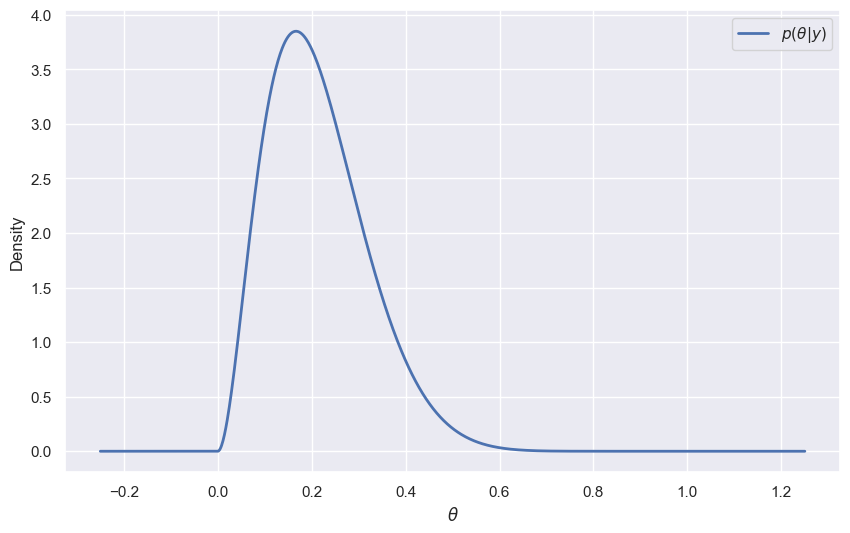

In [12]:
class BetaBinomial(object):
    """
    Beta-Binomial model:
      Data:    y ~ Binomial(N, theta)
      Prior:   theta ~ Beta(alpha0, beta0)
      Posterior: theta | y ~ Beta(alpha0 + y, beta0 + N - y)

    Attributes:
      y        : observed successes (scalar int)
      N        : number of trials (scalar int)
      alpha0   : prior alpha hyperparameter (scalar float)
      beta0    : prior beta hyperparameter (scalar float)
      alpha    : posterior alpha = alpha0 + y (scalar float)
      beta     : posterior beta  = beta0 + N - y (scalar float)
    """

    def __init__(self, y, N, alpha0=1., beta0=1.):
        # Inputs:
        #   y      : scalar int in [0, N], number of successes
        #   N      : scalar int >0, number of trials
        #   alpha0 : scalar >0, prior Beta(alpha0, beta0) alpha param
        #   beta0  : scalar >0, prior Beta(alpha0, beta0) beta param
        self.y, self.N = y, N
        self.alpha0, self.beta0 = alpha0, beta0
        # Posterior parameters (true):
        #   alpha = alpha0 + y
        #   beta  = beta0 + N - y
        self.alpha = alpha0 + y
        self.beta  = beta0 + N - y

    @property
    def posterior_mean(self):
        """
        Exact posterior mean of theta:
          E[theta | y] = alpha / (alpha + beta)
        Output: scalar float
        """
        return self.alpha / (self.alpha + self.beta)
    
    @property
    def posterior_variance(self):
        """
        Exact posterior variance of theta:
          Var(theta | y) = (alpha * beta) / [ (alpha+beta)^2 (alpha+beta+1) ]
        Output: scalar float
        """
        a, b = self.alpha, self.beta
        return (a * b) / ((a + b)**2 * (a + b + 1))

    def pdf(self, theta):
        """
        Posterior density p(theta | y), exact Beta pdf.
        Input:
          theta : array of shape (M,) or scalar in [0,1]
        Output:
          densities : array of shape (M,) or scalar
        Equation:
          p(theta|y) = Beta(theta | alpha, beta)
                     = (1 / B(alpha,beta)) * theta^{alpha-1} (1-theta)^{beta-1}
        """
        return beta_dist.pdf(theta, self.alpha, self.beta)
    
    def log_joint(self, theta_):
        """
        Log joint p(y, theta) up to constant in theta:
        Input:
          theta_ : array of shape (M,) or scalar in (0,1)
        Output:
          logp   : array of shape (M,) or scalar
        Equation:
          log p(y,theta) = log p(y|theta) + log p(theta)
                           = (alpha0+y-1)*log(theta)
                             + (beta0+N-y-1)*log(1-theta)
        """
        return (
            (self.alpha0 + self.y - 1) * jnp.log(theta_)
            + (self.beta0  + self.N - self.y - 1) * jnp.log(1 - theta_)
        )

    def grad(self, theta_):
        """
        Gradient w.r.t. theta of log joint p(y, theta):
        Input:
          theta_ : array of shape (M,) or scalar
        Output:
          grad   : array of shape (M,) or scalar
        Equation:
          d/dtheta log p = (alpha0+y-1)/theta
                           - (beta0+N-y-1)/(1-theta)
        """
        return (
            (self.alpha0 + self.y - 1) / theta_
            - (self.beta0  + self.N - self.y - 1) / (1 - theta_)
        )

    def hessian(self, theta_):
        """
        Hessian (second derivative) of log joint p(y,theta):
        Input:
          theta_ : array of shape (M,) or scalar
        Output:
          hess   : array of shape (M,) or scalar
        Equation:
          d^2/dtheta^2 log p =
            - (alpha0+y-1)/theta^2
            - (beta0+N-y-1)/(1-theta)^2
        """
        return (
            - (self.alpha0 + self.y - 1) / theta_**2
            - (self.beta0  + self.N - self.y - 1) / (1 - theta_)**2
        )

# Example usage:
# 1) Instantiate model for y=2 successes out of N=12 trials
#    model = BetaBinomial(y=2, N=12, alpha0=1.0, beta0=1.0)
# 2) Compute exact posterior mean/variance
#    m = model.posterior_mean       # scalar
#    v = model.posterior_variance   # scalar
# 3) Evaluate density on theta grid
theta_grid = jnp.linspace(0,1,1000)
# 4) Plot exact posterior
#    ax.plot(theta_grid, model.pdf(theta_grid))

# 5) Access log_joint, grad, hessian for Laplace approximation
#    logj = model.log_joint(theta_grid)
#    g    = model.grad(theta_grid)
#    H    = model.hessian(theta_grid)



# specify data and instantiate model
N = 12  # number of trials (scalar int)
y = 2   # number of observed successes (scalar int)
model = BetaBinomial(y, N)  # Beta-Binomial model instance

# plot exact posterior density
# theta_grid: shape (1000,), grid of theta values for plotting
theta_grid = jnp.linspace(-0.25, 1.25, 1000)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# model.pdf(theta_grid): shape (1000,), posterior density values
ax.plot(theta_grid, model.pdf(theta_grid), label='$p(\\theta|y)$', linewidth=2)
ax.set(xlabel='$\\theta$', ylabel='Density')
ax.legend()

# report exact posterior mean and variance
# Posterior mean: E[theta | y] = (alpha0 + y) / (alpha0 + beta0 + N)
# Posterior variance: Var(theta | y) = (alpha * beta) / [ (alpha+beta)^2 (alpha+beta+1) ]
print(f'The exact posterior mean is {model.posterior_mean:4.3f}')
print(f'The exact posterior variance is {model.posterior_variance:4.3f}')

**Task 2.3**: Go back up to the implementation of the class *BetaBinomial* and complete the implementation of the log joint as well as its gradient as hessian.

*Hints: The sanity below helps to verify your code. However, passing the test does not guarantee your code is correct.*

In [13]:
# sanity check of implementation
model = BetaBinomial(y=1, N=3, alpha0=1, beta0=1)
assert jnp.allclose(model.grad(1/4), 4/3), "Something appears to be wrong with your implementation of the gradient. Check your implementation."
assert jnp.allclose(model.grad(1/2), -2), "Something appears to be wrong with your implementation of the gradient. Check your implementation."
assert jnp.allclose(model.grad(3/4), -6.666666666666667), "Something appears to be wrong with your implementation of the gradient. Check your implementation."
assert jnp.allclose(model.hessian(1/4), -19.555555555555557), "Something appears to be wrong with your implementation of the hessian. Check your implementation."
assert jnp.allclose(model.hessian(1/2), -12), "Something appears to be wrong with your implementation of the hessian. Check your implementation."
assert jnp.allclose(model.hessian(3/4), -33.77777777777778), "Something appears to be wrong with your implementation of the hessian. Check your implementation."

If everything was implemented correctly, we can use almost any off-the-shelf optimizer for locating the mode of the posterior. We recommend using the *minimize* function from *scipy.optimize*. Note that our goal is to find the point that maximizes the posterior, whereas the *minimize*-function is designed for minimization and therefore, we need to flip the sign of the log_joint and its gradient when optimizing. Below we provide an example of how to use the optimizer in scipy:

In [14]:
# specify data and instantiate model
N = 12
y = 2
model = BetaBinomial(y, N)

# Optimize to find the MAP estimate of theta using scipy's minimize.
# We minimize the negative log joint (i.e., maximize the log joint).
# The gradient is also provided (negative because we are minimizing).
# The search is bounded to (1e-10, 1-1e-10) to avoid log(0) issues.
results = minimize(
    lambda x: -model.log_joint(x),                # Objective: negative log joint
    jac=lambda x: -model.grad(x),                 # Gradient: negative gradient of log joint
    x0=0.5,                                       # Initial guess for theta
    bounds=[(1e-10, 1-1e-10)]                     # Bounds to keep theta in (0,1)
)

# Print the full optimization results object for inspection
print(results)

if results.success:
    print('Optimization succeded!\n')
    print(f'\tSolution: theta         = {results.x[0]:+4.3}')         # MAP estimate for theta
    print(f'\t|gradient| at solution  = {results.jac[0]:+4.3e}')      # Gradient norm at solution (should be close to 0)
else:
    print('Optimization failed. Check your implementation.')

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 5.406734506395656
        x: [ 1.667e-01]
      nit: 8
      jac: [-2.579e-09]
     nfev: 10
     njev: 10
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
Optimization succeded!

	Solution: theta         = +0.167
	|gradient| at solution  = -2.579e-09


Finally, we turn our attention to the Laplace approximation itself.

**Task 2.4**: Complete the LaplaceApproximation1D class below. You need to complete the following functions:  `construct_approximation`, `taylor_approx``, `pdf`.

Text(0.5, 1.0, 'Posterior density for $\\theta$')

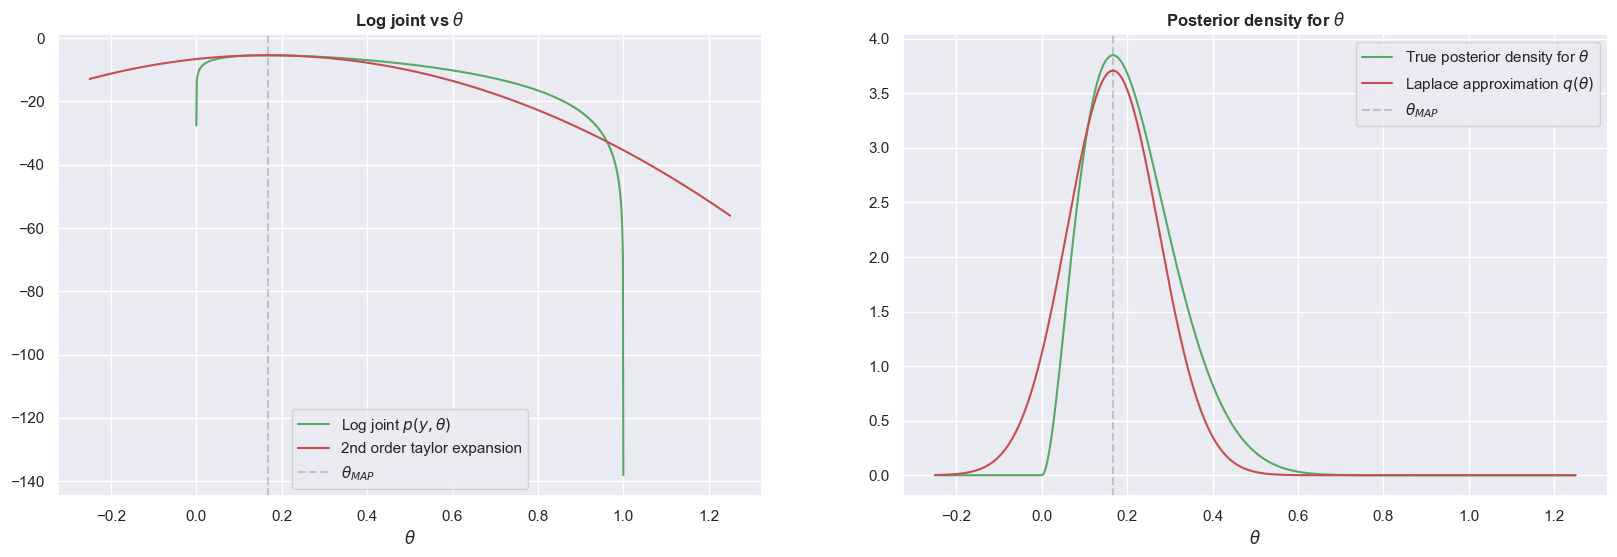

In [15]:
# Helper: log-PDF of a Normal distribution
# Input:
#   x : array of shape (M,) or scalar
#   m : array or scalar, mean, same shape broadcastable with x
#   v : array or scalar, variance >0, broadcastable
# Output:
#   log density: array of shape (M,) or scalar
# Equation:
#   log N(x|m,v) = - (x-m)^2/(2 v) - 0.5*log(2π v)
log_npdf = lambda x, m, v: -(x - m)**2/(2*v) - 0.5*jnp.log(2*jnp.pi*v)

# Helper: PDF of a Normal via exponentiating log-PDF
# Input/output shapes same as log_npdf
npdf = lambda x, m, v: jnp.exp(log_npdf(x, m, v))

class LaplaceApproximation1D(object):
    """
    Compute a 1D Laplace (Gaussian) approximation for a model's posterior.

    Attributes:
      model         : object with methods log_joint(theta), grad(theta), hessian(theta)
      param_MAP     : scalar, mode of posterior (= argmax log_joint)
      Hessian       : scalar, second derivative of log_joint at mode
      mean          : same as param_MAP
      variance      : scalar, = -1 / Hessian

    Methods:
      construct_approximation()   : runs optimization to find mode and Hessian
      taylor_approx(theta)       : second-order Taylor of log_joint at mode
      pdf(theta)                 : Gaussian pdf of approximate posterior at theta
    """

    def __init__(self, model, init_param=0):
        """
        Initialize LaplaceApproximation1D.

        Inputs:
          model      : object implementing log_joint(theta), grad(theta), hessian(theta)
          init_param : initial guess for optimization (scalar)
        """
        self.model = model
        self.param_MAP = None      # to be set after optimization
        self.Hessian = None        # to be set after optimization
        self.mean = None           # to be set after optimization
        self.variance = None       # to be set after optimization
        # Build the Laplace approximation immediately
        self.construct_approximation()

    def construct_approximation(self):
        """
        Construct the Laplace approximation by:
        1) Finding the MAP parameter (mode) by optimizing -log_joint.
        2) Computing Hessian at the MAP: A = d^2/dθ^2 log_joint(θ) at θ=param_MAP.
        3) Setting Gaussian approx mean=param_MAP, var=-1/A.

        Equations:
          θ_MAP = argmax_θ log_joint(θ)
          A = d^2/dθ^2 log_joint(θ) |_{θ=θ_MAP}
          q(θ) = N(θ | θ_MAP, -1/A)

        Output:
          Sets self.param_MAP (scalar), self.Hessian (scalar),
          self.mean (scalar), self.variance (scalar)
        """
        # 1) optimize negative log joint to find mode
        opt_results = minimize(
            fun = lambda x: -self.model.log_joint(x),     # minimize negative log joint
            jac = lambda x: -self.model.grad(x),          # gradient of negative log joint
            x0 = init_param if 'init_param' in locals() else 0.5,
            bounds=[(1e-10, 1-1e-10)]                     # restrict θ to (0,1)
        )
        if not opt_results.success:
            raise ValueError(f"Optimization failed: {opt_results}")

        # 2) extract mode and evaluate second derivative (Hessian)
        self.param_MAP = opt_results.x.item()           # scalar, θ_MAP
        self.Hessian  = self.model.hessian(self.param_MAP)  # scalar, A
        # 3) set Gaussian parameters
        self.mean     = self.param_MAP                   # mode
        self.variance = -1.0 / self.Hessian              # -1/A

    def taylor_approx(self, theta):
        """
        Compute second-order Taylor expansion of log_joint around mean.

        Input:
          theta : array of shape (M,) or scalar

        Output:
          approximation: array of shape (M,) or scalar

        Equation:
          f(θ) ≈ f(θ₀) + ½ A (θ - θ₀)^2,
          where A = d^2/dθ^2 log_joint(θ₀), θ₀ = self.mean
        """
        return (
            self.model.log_joint(self.mean)
            + 0.5 * self.Hessian * (theta - self.mean)**2
        )

    def pdf(self, theta):
        """
        Evaluate the Laplace Gaussian approximation q(θ) at given points.

        Input:
          theta : array or scalar

        Output:
          q_vals: array or scalar, same shape

        Equation:
          q(θ) = N(θ | mean, variance)
               = exp(log_npdf(θ, mean, variance)).
        """
        return npdf(theta, self.mean, self.variance)

# Example usage:
#  model = BetaBinomial(y, N)
#  laplace = LaplaceApproximation1D(model)
#  theta_vals = jnp.linspace(0,1,100)
#  # plot true posterior vs Laplace
#  ax.plot(theta_vals, model.pdf(theta_vals), 'g', label='True')
#  ax.plot(theta_vals, laplace.pdf(theta_vals), 'r', label='Laplace')
#  ax.legend()


# Specify data and instantiate model
N = 12   # number of trials (scalar)
y = 2    # number of successes (scalar)
model = BetaBinomial(y, N)  # model object with log_joint, grad, hessian

# Build Laplace approximation for posterior p(θ|y)
laplace_approx = LaplaceApproximation1D(model)

# Plotting
fig, ax = plt.subplots(1,2, figsize=(20, 6))

# theta_space_unit: θ in (0,1), shape (1000,)
theta_space_unit = jnp.linspace(1e-6, 1-1e-6, 1000)
# theta_space: θ in [-0.25, 1.25], shape (1000,)
theta_space = jnp.linspace(-0.25, 1.25, 1000)

# Plot log joint and its Taylor expansion
ax[0].plot(
    theta_space_unit, 
    model.log_joint(theta_space_unit), 
    'g', label='Log joint $p(y, \\theta)$'
)
ax[0].plot(
    theta_space, 
    laplace_approx.taylor_approx(theta_space), 
    color='r', label='2nd order taylor expansion'
)
ax[0].axvline(
    laplace_approx.mean, color='k', linestyle='--', alpha=0.2, label='$\\theta_{MAP}$'
)
ax[0].set(xlabel='$\\theta$')
ax[0].legend()
ax[0].set_title('Log joint vs $\\theta$', fontweight='bold')

# Plot true posterior and Laplace approximation
ax[1].plot(
    theta_space, 
    model.pdf(theta_space),  
    'g', label='True posterior density for $\\theta$'
)
ax[1].plot(
    theta_space, 
    laplace_approx.pdf(theta_space), 
    color='r', label='Laplace approximation $q(\\theta)$'
)
ax[1].axvline(
    laplace_approx.mean, color='k', linestyle='--', alpha=0.2, label='$\\theta_{MAP}$'
)
ax[1].set(xlabel='$\\theta$')
ax[1].legend()
ax[1].set_title('Posterior density for $\\theta$', fontweight='bold')

**Task 2.5**: How well does the Laplace approximation $q(\theta)$ resemble the true posterior? Experiment with different number of trials $N$ and successes $y$ and explore how the change affects the quality of the approximation. Try the following pairs $(y, N) \in \left\lbrace (1, 3), (10, 30), (10, 300), (1, 20) \right\rbrace$. Does the Laplace approximation 'respect' the domain of the parameter $\theta$?
 

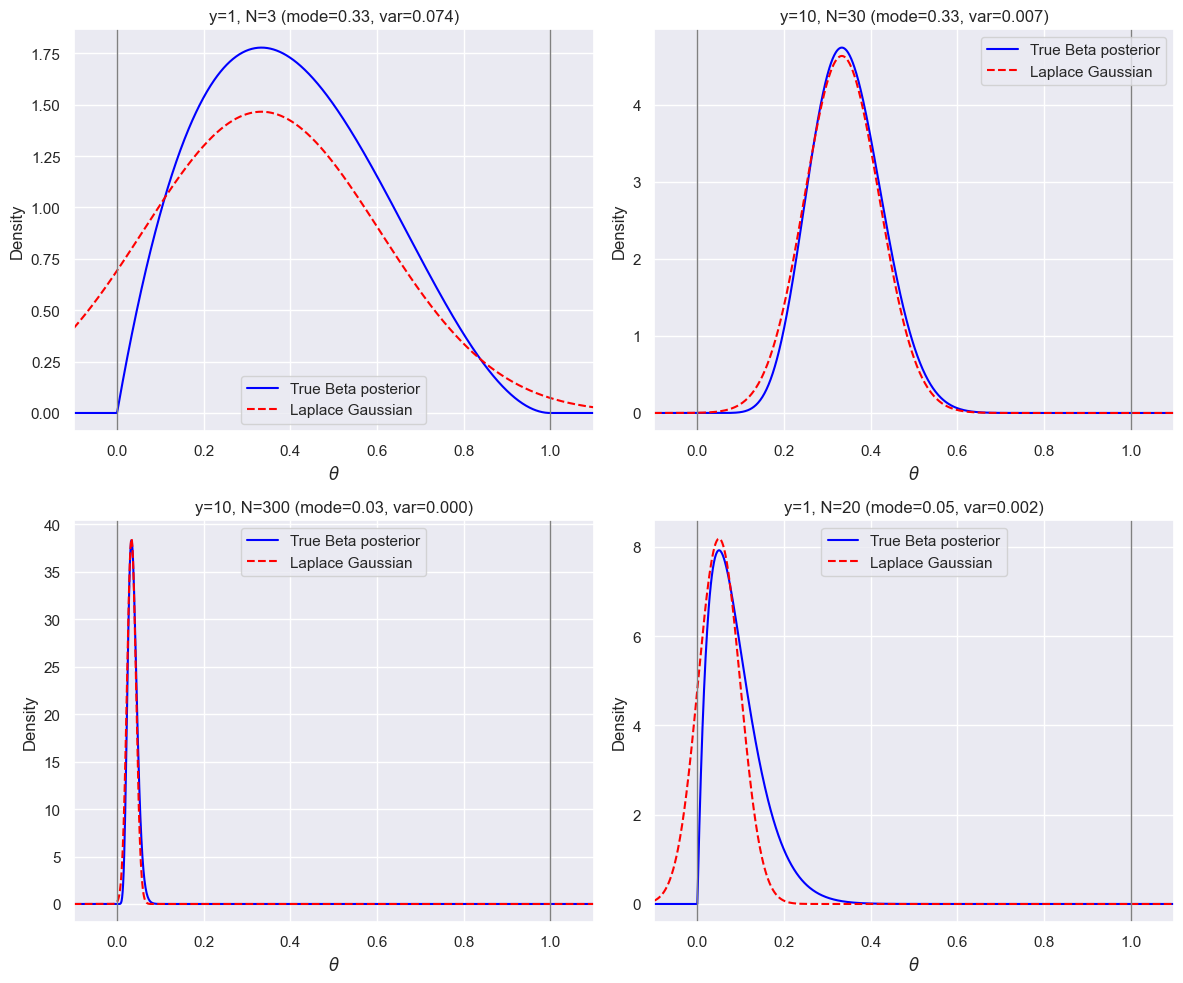

In [16]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Define theta grid (slightly beyond [0,1] to show Gaussian tail)
theta_grid = jnp.linspace(-0.1, 1.1, 1000)

# Scenarios to test
scenarios = [(1, 3), (10, 30), (10, 300), (1, 20)]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (y, N) in zip(axes, scenarios):
    # Instantiate true model and Laplace approximation
    model = BetaBinomial(y, N)
    la = LaplaceApproximation1D(model)
    
    # Compute true posterior and Laplace PDF
    true_pdf = model.pdf(theta_grid)
    laplace_pdf = la.pdf(theta_grid)
    
    # Plot
    ax.plot(theta_grid, true_pdf, label='True Beta posterior', color='blue')
    ax.plot(theta_grid, laplace_pdf, label='Laplace Gaussian', color='red', linestyle='--')
    ax.axvline(0, color='gray', linewidth=1)
    ax.axvline(1, color='gray', linewidth=1)
    ax.set_xlim(-0.1, 1.1)
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel('Density')
    ax.set_title(f'y={y}, N={N} (mode={la.mean:.2f}, var={la.variance:.3f})')
    ax.legend()

fig.tight_layout()
plt.show()


___________
# Part 3:  Implementing the logistic regression model

Equipped with the Laplace approximation, we will now turn our attention towards the Bayesian logistic regression model for binary classification. Recall, the model is defined as

$$\begin{align*}
y_n|\mathbf{w}, \mathbf{x}_n &\sim \text{Ber}(\sigma(f(\textbf{x}_n)))\\
\mathbf{w} &\sim \mathcal{N}(0, \alpha^{-1}\mathbf{I}),
\end{align*}$$

where $f(\textbf{x})$ is a linear model with parameters $\textbf{w}$ given by

$$\begin{align*}
f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}.
\end{align*}
$$



Our goal for the exercise is two-fold: 1) we want to obtain the posterior distribution $p(\textbf{w}|\mathbf{y})$ to be able reason about the parameters in the linear model, and 2) we want to obtain the posterior predictive distribution $p(y^*|\textbf{y}, \textbf{x}^*)$ for a new input point $\textbf{x}^*$. Since logistic regression is a **non-conjugate** model, we need to resort to the Laplace approximation for approximate inference $p(\textbf{w}|\textbf{y}) \approx q(\textbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S})$.

First, we will write up the log joint distribution using the short-hand notation $f_n \equiv f(\mathbf{x}_n) = \mathbf{w}^T \mathbf{x}_n$:

$$\begin{align*}
\log p(\mathbf{y}, \mathbf{w}) &= \log p(\mathbf{y}|\mathbf{w}) + \log p(\mathbf{w})\\
&= \sum_{n=1}^N \log \text{Ber}(y_n|\sigma(f_n))+  \log \mathcal{N}(\mathbf{w}|0, \alpha^{-1}\mathbf{I})\\
&= \sum_{n=1}^N \left[(1-y_n)\log(1-\sigma(f_n)) + y_n\log(\sigma(f_n)) \right] - \frac{\alpha}{2}\mathbf{w}^T \mathbf{w} + \text{const.}
\end{align*}
$$

In order to implement the Laplace approximation, we need gradient and Hessian of the log joint distribution.
From this distribution, we can derive the gradient and Hessian. Calculating the gradient yields:

$$\begin{align*}
\nabla_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w}) &= \sum_{n=1}^N \left[(1-y_n)\nabla_{\mathbf{w}}\log(\sigma(-f_n)) + y_n\nabla_{\mathbf{w}}\log(\sigma(f_n)) \right] - \frac{\alpha}{2}\nabla_{\mathbf{w}}\mathbf{w}^T \mathbf{w} + \text{const.}\\
%
&= \sum_{n=1}^N \left[(1-y_n)\nabla_{\mathbf{w}}\log(\sigma(-f_n)) + y_n\nabla_{\mathbf{w}}\log(\sigma(f_n)) \right] - \alpha \mathbf{w} + \text{const.}
\end{align*}$$

By repeated use of the chain-rule, we evaluate the derivative of $\nabla_{\mathbf{w}}\log(\sigma(f_n))$

$$
\begin{align*}
\nabla_{\mathbf{w}}\log(\sigma(f_n)) &= \nabla_{\mathbf{w}} \log \frac{1}{1+e^{-f_n}} = -\nabla_{\mathbf{w}} \log (1+e^{-f_n})\\
&= - \frac{1}{1+e^{-f_n}} \nabla_{\mathbf{w}}\left(1+e^{-f_n}\right) \\
&= \frac{1}{1+e^{-f_n}}e^{-f_n} \nabla_{\mathbf{w}} f_n \\
&= \frac{1}{1+e^{-f_n}}e^{-f_n} \nabla_{\mathbf{w}} \bm{w}^T \mathbf{x}_n \\
&= \frac{e^{-f_n}}{1+e^{-f_n}}\mathbf{x}_n \\
&= \left[1-\sigma(f_n)\right]\mathbf{x}_n \\
\end{align*}
$$

and a similar line of calculations yields

$$
\begin{align*}
\nabla_{\mathbf{w}}\log(1-\sigma(f_n)) &=  -\sigma(f_n) \textbf{x}_n.
\end{align*}
$$

Substituting back into the expression yields:

$$\begin{align*}
\nabla_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w}) &= \sum_{n=1}^N \left[-(1-y_n)\sigma(f_n) \textbf{x}_n + y_n\left[1-\sigma(f_n)\right]\mathbf{x}_n\right] -\alpha \mathbf{w}\\
%
&= \sum_{n=1}^N \left[\sigma(f_n)+y_n\sigma(f_n) + y_n-y_n\sigma(f_n)\right]\mathbf{x}_n - \alpha \mathbf{w}\\
%
&= -\sum_{n=1}^N \left[\sigma(f_n) - y_n\right]\mathbf{x}_n - \alpha \mathbf{w}
\end{align*}$$

Finally, we compute the Hessian
$$\begin{align*}
\mathcal{H}(\textbf{w})_{ij} = \frac{\partial^2}{\partial w_i \partial w_j} \log p(\mathbf{y}, \mathbf{w}) &= \frac{\partial}{\partial w_i}  \left[ -\sum_{n=1}^N \left[\sigma(f_n) - y_n\right]\mathbf{x}_n - \alpha \mathbf{w}\right]_j\\
%
&= -\sum_{n=1}^N \frac{\partial}{\partial w_i} \left[\sigma(f_n) - y_n\right]x_{n,j} - \alpha  \delta_{ij}\\
%
&= -\sum_{n=1}^N  \frac{\partial}{\partial w_i}\sigma(f_n)x_{n,j} - \alpha \delta_{ij}\\
%
&= -\sum_{n=1}^N  (1-\sigma(f_n))\sigma(f_n)x_{n,i}x_{n,j} - \alpha  \delta_{ij}
\end{align*}$$
where $\delta_{ij}$ is **Kronecker's delta function** (not to be confused with Dirac's delta function):
$$\begin{align*}
\delta_{ij} = \begin{cases}1 & \text{if } i = j\\0&\text{otherwise}\end{cases}.

\end{align*}$$
Hence,
$$\begin{align*}
\mathcal{H}(\textbf{w}) = \nabla^2_{\textbf{w}} \log p(\mathbf{y}, \mathbf{w}) = -\sum_{n=1}^N (1-\sigma(f_n))\sigma(f_n) \textbf{x}_n\textbf{x}_n^T - \alpha \textbf{I} = -\textbf{X}\textbf{S}\textbf{X}^T - \alpha \textbf{I},
\end{align*}
$$

where $\textbf{S} \in \mathbb{R}^{N \times N}$ is a diagonal matrix with $S_{nn} = (1-\sigma(f_n))\sigma(f_n)$ and $\textbf{X} \in \mathbb{R}^{N \times D}$ is the design matrix such  that $\textbf{x}_n$ will be the $n$'th row of $\textbf{X}$.

Recall, sometimes we want to use a **feature transformation** $\phi(\textbf{x})$ to model non-linear dependencies, e.g. $\phi(\textbf{x}_n) = \begin{bmatrix} 1 & x_{n,1} & x_{n,2} & x_{n,1}^2 & x_{n,2}^2 \end{bmatrix}$ with $f(\mathbf{x}_n) = \mathbf{w}^T \phi(\mathbf{x}_n)$.


For plotting purpose, we will need a class for evaluating function on 2D grids. This is similar to the Grid2D-class used in exercise2, but now we have also equipped it with a function for plotting heatmaps.

____________

In [17]:
class Grid2D(object):
    """
    Helper for evaluating a 2D function 'func' on a grid defined by two 1D arrays.

    Attributes:
      dim1        : 1D array of length I (coordinate values for first axis)
      dim2        : 1D array of length J (coordinate values for second axis)
      grid_size   : tuple (I, J)
      dim1_grid   : 2D array of shape (I, J) with repeated rows of dim1
      dim2_grid   : 2D array of shape (I, J) with repeated columns of dim2
      func        : function mapping array of shape (M,2) -> (M,) or (M,1)
      values      : 2D array of shape (I, J) with func evaluated at each grid point

    Methods:
      plot_contours(ax, ...) : contour plot of f(values)
      plot_heatmap(ax, ...)  : heatmap (pcolormesh) of f(values)
    """

    def __init__(self, dim1, dim2, func, name="Grid2D"):
        # Inputs:
        #   dim1 : array of shape (I,)
        #   dim2 : array of shape (J,)
        #   func : callable mapping array of shape (M,2) to (M,) (log-density or density)
        #   name : string for plot titles
        self.dim1 = dim1
        self.dim2 = dim2
        self.grid_size = (len(self.dim1), len(self.dim2))  # (I, J)
        # Create full coordinate grids:
        #   dim1_grid[i,j] = dim1[i]
        #   dim2_grid[i,j] = dim2[j]
        self.dim1_grid, self.dim2_grid = jnp.meshgrid(dim1, dim2, indexing='ij')  # both (I, J)
        self.func = func
        self.name = name
        
        # Evaluate func on each grid point:
        # 1) stack points into shape (I*J, 2)
        params_flat = jnp.column_stack((
            self.dim1_grid.flatten(),  # length I*J
            self.dim2_grid.flatten()   # length I*J
        ))  # shape: (M, 2) with M = I*J
        # 2) call func and reshape back to grid
        #    func returns shape (M,) or (M,1)
        self.values = (self.func(params_flat)
                       .squeeze()
                       .reshape(self.grid_size))    # shape: (I, J)

    def plot_contours(self, ax,
                      color='b',
                      num_contours=10,
                      f=lambda x: x,
                      alpha=1.0,
                      title=None):
        """
        Contour-plot f(values) on the grid.

        Inputs:
          ax           : matplotlib Axes
          color        : line color
          num_contours : number of contour levels
          f            : function mapping values array -> display array (e.g. exp for log-dens)
          alpha        : line transparency
          title        : optional title override

        Effects:
          plots contour of shape (num_contours) on ax
          sets labels '$w_1$' and '$w_2$'
        """
        # Transpose so axes align: X-axis=dim1, Y-axis=dim2
        Z = f(self.values).T  # shape: (J, I)
        ax.contour(self.dim1, self.dim2, Z, num_contours, colors=color, alpha=alpha)
        ax.set(xlabel='$w_1$', ylabel='$w_2$')
        ax.set_title(title or self.name, fontweight='bold')

    def plot_heatmap(self, ax,
                     f=lambda x: x,
                     clim=[0, 1],
                     colorbar=False):
        """
        Heatmap (pcolormesh) of f(values) on the grid.

        Inputs:
          ax       : matplotlib Axes
          f        : transform on values (e.g. exp to convert log->density)
          clim     : [vmin, vmax] for color limits
          colorbar : whether to display a colorbar

        Effects:
          plots pcolormesh of shape (J, I) with cmap RdBu_r
          sets labels '$w_1$' and '$w_2$'
          optionally adds colorbar
        """
        Z = f(self.values).T  # shape: (J, I)
        img = ax.pcolormesh(self.dim1, self.dim2, Z,
                            cmap=plt.cm.RdBu_r,
                            clim=clim)
        ax.set(xlabel='$w_1$', ylabel='$w_2$')
        ax.set_title(self.name, fontweight='bold')
        if colorbar:
            from mpl_toolkits.axes_grid1 import make_axes_locatable
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig = ax.get_figure()
            fig.colorbar(img, cax=cax)


______________

**Task 3.1**: Below you are given a template for a logistic regression implementation. Complete the implementation of the gradient and hessian using the equations above.

If the gradient is implemented correct, the cell below will locate the MAP solution using gradient-based optimization and plot the MAP solution on the of the contours of the posterior:

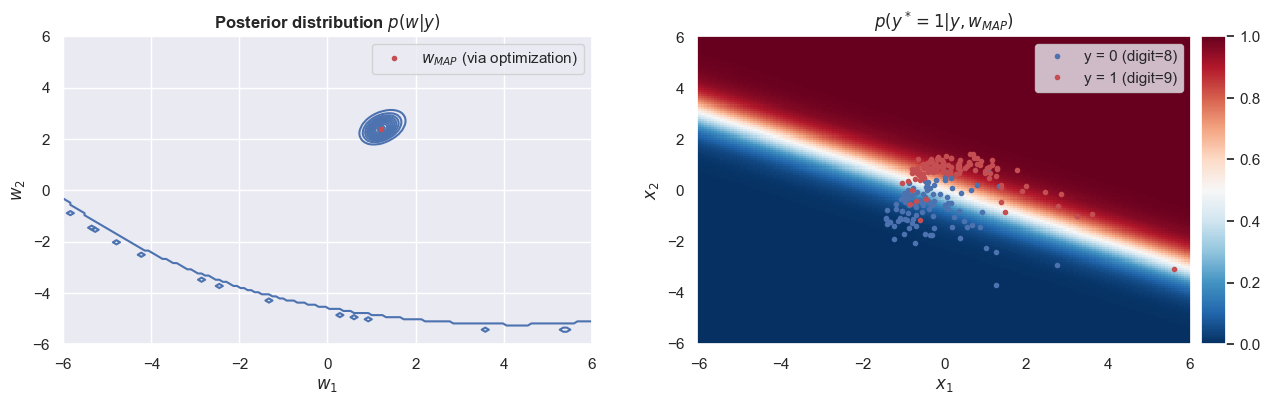

In [24]:
sigmoid = lambda x: 1./(1 + jnp.exp(-x))

class LogisticRegression(object):
    """
    Bayesian Logistic Regression with MAP estimation.

    Parameters
    ----------
    X : array-like, shape (N, D)
        Training data features.
    y : array-like, shape (N,)
        Training data binary labels (0 or 1).
    feature_transformation : callable, optional
        Function to transform features (default: identity).
    alpha : float, optional
        Precision (inverse variance) of Gaussian prior on weights.

    Attributes
    ----------
    X0 : array-like, shape (N, D)
        Original input features.
    y : array-like, shape (N,)
        Training labels.
    alpha : float
        Prior precision.
    feature_transformation : callable
        Feature transformation function.
    X : array-like, shape (N, D)
        Transformed and standardized features.
    X_mean : array-like, shape (D,)
        Mean of each feature (for standardization).
    X_std : array-like, shape (D,)
        Std of each feature (for standardization).
    N : int
        Number of training samples.
    D : int
        Number of features.
    w_MAP : array-like, shape (D,)
        MAP estimate of weights.
    """

    def __init__(self, X, y, feature_transformation=lambda x: x, alpha=1.):
        # Store data and hyperparameters
        self.X0 = X
        self.y = y
        self.alpha = alpha
        self.feature_transformation = feature_transformation

        # Apply feature transformation and standardize
        self.X = feature_transformation(self.X0)
        self.X_mean = jnp.mean(self.X, 0)
        self.X_std = jnp.std(self.X, 0)
        # Avoid division by zero in standardization
        self.X_std.at[self.X_std == 0].set(1)
        self.X = self.preprocess(X)

        # Store number of training data and number of features
        self.N, self.D = self.X.shape

        # Get MAP by optimization
        self.w_MAP = self.get_MAP()

    def preprocess(self, X_):
        """
        Standardize features using training mean and std.

        Parameters
        ----------
        X_ : array-like, shape (N, D)
            Input features.

        Returns
        -------
        X : array-like, shape (N, D)
            Standardized features.
        """
        X = self.feature_transformation(X_)
        return (X - self.X_mean)/self.X_std

    def predict(self, X, w):
        """
        Predict probability p(y=1|X, w) using the logistic sigmoid.

        Parameters
        ----------
        X : array-like, shape (N, D)
            Input features.
        w : array-like, shape (D,)
            Weight vector.

        Returns
        -------
        p : array-like, shape (N,)
            Predicted probabilities.
        Equation: p = sigmoid(w^T x)
        """
        f = w@X.T  # shape: (N,)
        return sigmoid(f)

    def log_joint(self, w):
        """
        Compute the log joint probability log p(y, w) for each row in w.

        Parameters
        ----------
        w : array-like, shape (M, D)
            Weight vectors (M samples).

        Returns
        -------
        log_joint : array-like, shape (M,)
            Log joint probabilities for each weight vector.

        Equation:
            log p(y, w) = log p(w) + sum_n log p(y_n | x_n, w)
            log p(w) ~ N(0, alpha^{-1} I)
            log p(y_n | x_n, w) = y_n log p_n + (1-y_n) log (1-p_n)
        """
        p = self.predict(self.X, w)
        log_prior = jnp.sum(log_npdf(w, 0, 1./self.alpha), axis=1)
        log_lik = binom_dist.logpmf(self.y, p=p, n=1)
        log_joint = log_prior + log_lik.sum(axis=1)
        return log_joint

    def hessian(self, w):
        """
        Compute the Hessian of the log joint at w.

        Parameters
        ----------
        w : array-like, shape (1, D)
            Weight vector.

        Returns
        -------
        H : array-like, shape (D, D)
            Hessian matrix.

        Equation:
            H = -X^T diag(p*(1-p)) X - alpha * I
        """
        p = self.predict(self.X, w)
        v = p*(1-p)  # shape: (N,)
        H = -self.X.T @ jnp.diag(v) @ self.X - self.alpha*jnp.identity(self.D)
        assert H.shape == (self.D, self.D), f"The shape of the Hessians appears to be wrong. Expected shape ({self.D}, {self.D}), but received {H.shape}. Check your implementation"
        return H

    def grad(self, w):
        """
        Compute the gradient of the log joint at w.

        Parameters
        ----------
        w : array-like, shape (1, D)
            Weight vector.

        Returns
        -------
        grad : array-like, shape (1, D)
            Gradient vector.

        Equation:
            grad = -sum_n (p_n - y_n) x_n - alpha * w
        """
        p = self.predict(self.X, w)
        err = p - self.y  # shape: (N,)
        grad = -jnp.sum(err.T*self.X, axis=0) - self.alpha*w
        assert grad.shape == (1, self.D), f"The shape of the gradient appears to be wrong. Expected shape (1, {self.D}), but received {grad.shape}. Check your implementation"
        return grad

    def get_MAP(self):
        """
        Find the MAP estimate of weights by maximizing the log joint.

        Returns
        -------
        w_MAP : array-like, shape (D,)
            MAP estimate of weights.
        """
        init_w = jnp.zeros(self.D)
        results = minimize(lambda x: -self.log_joint(x[None, :]), jac=lambda x: -self.grad(x[None, :]).flatten(), x0=init_w)
        if not results.success:
            print(results)
            raise ValueError('Optimization failed')
        w_MAP = results.x
        return w_MAP
        
# instantiate model
model = LogisticRegression(Xtrain, ytrain)

# function for making prediction using w_MAP point estimate
pred_MAP = lambda x: model.predict(model.preprocess(x), model.w_MAP)

# prep grid
dim1, dim2 = jnp.linspace(-6, 6, 150), jnp.linspace(-6, 6, 149)
grid_log_joint = Grid2D(dim1, dim2, model.log_joint, name='Posterior distribution $p(w|y)$')
grid_predictions = Grid2D(dim1, dim2, pred_MAP, name='$p(y^*=1|y, w_{MAP})$')

# plot
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
grid_log_joint.plot_contours(ax[0], f=jnp.exp,)
ax[0].plot(model.w_MAP[0], model.w_MAP[1], 'r.', label='$w_{MAP}$ (via optimization)')
ax[0].legend()

plot_data(ax[1], Xtrain, ytrain, 'Training data')
grid_predictions.plot_heatmap(ax[1], colorbar=True)
ax[1].set(xlabel='$x_1$', ylabel='$x_2$');

Using feature transformations, we can model non-linear decision boundaries, but we cannot easily visualize the posterior anymore (**why not?**):

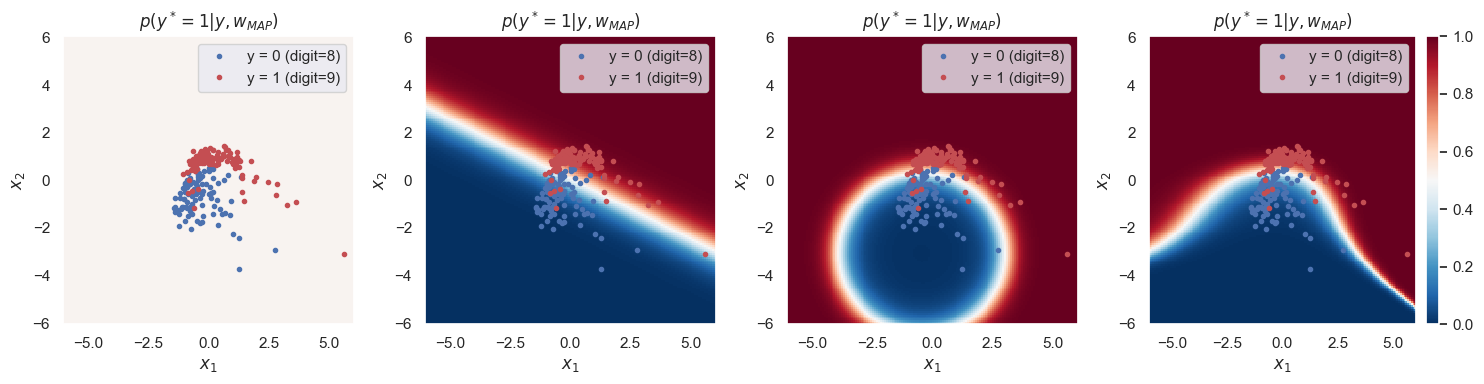

In [25]:
# simple polymials as feature transformation
def feature_transformation(x, order=10):
    return jnp.column_stack([x**m for m in range(order+1)])

# prep grid
dim1, dim2 = jnp.linspace(-6, 6, 150), jnp.linspace(-6, 6, 149)

# plot
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

for i in range(4):

    # instantiate model
    model = LogisticRegression(Xtrain, ytrain, feature_transformation=lambda x: feature_transformation(x, order=i))

    # function for making prediction using w_MAP point estimate
    pred_MAP = lambda x: model.predict(model.preprocess(x), model.w_MAP)

    # evaluate prediction for grid
    grid_predictions = Grid2D(dim1, dim2, pred_MAP, name='$p(y^*=1|y, w_{MAP})$')

    # plot
    plot_data(ax[i], Xtrain, ytrain, 'Training data')
    grid_predictions.plot_heatmap(ax[i], colorbar=True if i == 3 else False)
    ax[i].set(xlabel='$x_1$', ylabel='$x_2$')

fig.tight_layout()

# Part 4:  Implementing the Laplace approximation for logistic regression

We are now ready to implement the Laplace approximation. We have already done most of the hard word, now we simply need to combine all the pieces. For the purpose of validating our implementation, we will temporarily remove the feature transformation again.

**Task 4.1**: Complete the implementation the Laplace approximation below. To verify your implementation, we will generate 200 samples from the posterior, $\textbf{w}^i \sim q(\textbf{w})$ and the plot the samples on top of the contours of posterior distribution. You should expect to see samples covering the contours of the posterior distribution.

'\nKey concepts in this visualization:\n1. True posterior p(w|y): Shown as contour lines\n2. MAP estimate: Red point at the mode of the posterior\n3. Laplace approximation: Gaussian centered at MAP with covariance -H⁻¹\n4. Green samples: Drawn from the Laplace approximation N(w_MAP, -H⁻¹)\n\nThe quality of approximation depends on:\n- How Gaussian-like the true posterior is\n- Amount of data (more data → better approximation)\n- Model complexity\n'

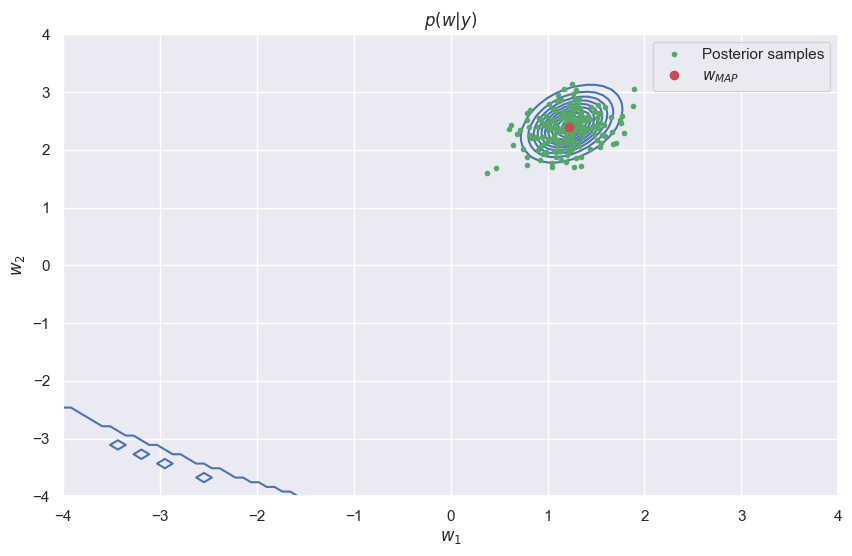

In [29]:
class LaplaceApproximation(object):
    """
    Laplace approximation for the posterior distribution
    
    Approximates p(w|y) ≈ q(w) = N(w|m, S)
    where:
        m = w_MAP (posterior mode)
        S = -H⁻¹ (negative inverse Hessian at MAP)
        H = ∇²log p(w|y)|_{w=w_MAP}
    
    The approximation is based on a 2nd-order Taylor expansion
    of log p(w|y) around w_MAP
    """

    def __init__(self, model):
        """ 
        Initialize Laplace approximation q(w) = N(m, S)
        
        Args:
            model: LogisticRegression object with computed w_MAP
        """
        # Store the model
        self.model = model

        # Implement Laplace approximation components:
        
        # 1. Posterior mean = MAP estimate
        # Shape: (D,)
        self.posterior_mean = model.w_MAP
        
        # 2. Hessian matrix at MAP: H = ∇²log p(w|y)|_{w=w_MAP}
        # Shape: (D, D)
        self.posterior_hessian = model.hessian(model.w_MAP)
        
        # 3. Posterior covariance: S = -H⁻¹
        # The negative sign because H is the negative Hessian of log posterior
        # Shape: (D, D)
        self.posterior_cov = -jnp.linalg.inv(self.posterior_hessian)

        # Sanity checks to ensure correct dimensions
        assert self.posterior_mean.shape == (model.D,), f"The shape of the posterior mean appears wrong. Check your implementaion."
        assert self.posterior_hessian.shape == (model.D, model.D), f"The shape of the posterior Hessian appears wrong. Check your implementaion."
        assert self.posterior_cov.shape == (model.D, model.D), f"The shape of the posterior covariance appears wrong. Check your implementaion."

    def log_pdf(self, w):
        """
        Evaluate log density of approximate posterior at w
        
        Args:
            w: array, shape (M, D) - weight vectors to evaluate
            
        Returns:
            log_q: array, shape (M,) - log probability values
            
        Equation:
            log q(w) = log N(w|m, S)
                     = -½(w-m)ᵀS⁻¹(w-m) - ½log|2πS|
        """
        return mvn.logpdf(w, self.posterior_mean.ravel(), self.posterior_cov)
    
    def posterior_samples(self, key, num_samples):
        """
        Generate samples from the approximate posterior distribution
        
        Args:
            key: JAX random key
            num_samples: int - number of samples to generate
            
        Returns:
            samples: array, shape (num_samples, D) - samples from q(w)
            
        Sampling: w ~ N(m, S)
        """
        return random.multivariate_normal(key, self.posterior_mean, self.posterior_cov, shape=(num_samples, ))


# Initialize model and compute MAP estimate
model = LogisticRegression(Xtrain, ytrain)

# Create Laplace approximation around MAP
# q(w) = N(w|w_MAP, -H⁻¹)
laplace = LaplaceApproximation(model)

# Generate samples from the approximate posterior
# These samples approximate the true posterior distribution
key = random.PRNGKey(1)
w_samples = laplace.posterior_samples(key, 200)  # Shape: (200, D)

# Create 2D grid for visualization in weight space
dim1, dim2 = jnp.linspace(-4, 4, 100), jnp.linspace(-4, 4, 100)
grid_log_joint = Grid2D(dim1, dim2, model.log_joint, name='$p(w|y)$')

# Plot comparison of true posterior vs Laplace approximation
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# True posterior contours (exponentiated log joint)
grid_log_joint.plot_contours(ax, f=jnp.exp)

# Samples from Laplace approximation
ax.plot(w_samples[:, 0], w_samples[:, 1], 'g.', label='Posterior samples')

# MAP estimate (center of Laplace approximation)
ax.plot(model.w_MAP[0], model.w_MAP[1], 'ro', label='$w_{MAP}$')

ax.legend();

"""
Key concepts in this visualization:
1. True posterior p(w|y): Shown as contour lines
2. MAP estimate: Red point at the mode of the posterior
3. Laplace approximation: Gaussian centered at MAP with covariance -H⁻¹
4. Green samples: Drawn from the Laplace approximation N(w_MAP, -H⁻¹)

The quality of approximation depends on:
- How Gaussian-like the true posterior is
- Amount of data (more data → better approximation)
- Model complexity
"""

**Task 4.2**: Report the (approximate) posterior mean and covariance of $p(\mathbf{w}|\mathbf{y})$

**Solution**

In [30]:
print(f'Posterior mean:\n{onp.array2string(laplace.posterior_mean, precision=2)}\n')
print(f'Posterior cov:\n{onp.array2string(laplace.posterior_cov, precision=2)}')

Posterior mean:
[1.22 2.4 ]

Posterior cov:
[[0.06 0.03]
 [0.03 0.09]]


**End of solution**

## Part 5:  Approximating the posterior predictive distribution

Now that we have obtained our Laplace approximation, i.e. $p(\textbf{w}|\textbf{y}) \approx q(\textbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S})$, it is finally time to make predictions. Our goal is to approximate the posterior predictive distribution $p(y^* = 1|\mathbf{y}, \mathbf{x}^*)$, which can be approximated as

$$\begin{align*}
p(y^*=1|\textbf{y}, \textbf{x}^*) = \int p(y^*=1|\textbf{w}, \textbf{x}^*) p(\textbf{w}|\textbf{y}) \text{d}\textbf{w} \approx \int p(y^*=1|\textbf{w}, \textbf{x}^*) q(\textbf{w}) \text{d}\textbf{w} = \int \sigma(\mathbf{w}^T \mathbf{x}^*) \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S}) \text{d} \mathbf{w} = \int \sigma(f^*) \mathcal{N}(f^*|m^*, v^*) \text{d} f^*,
\end{align*}$$

where $m^* = \mathbf{m}^T \mathbf{x} ^*$ and  and $v^* = (\mathbf{x}^*)^T  \mathbf{S} \mathbf{x}_*$. In this exercise, we will implement three options for approximating the above integral:

**The plug-in approximation**

The first option is the **plug-in** aproximation using $\mathbf{m} = \mathbf{w}_{\text{MAP}}$:

$$\begin{align*}
p(y^*=1|\textbf{y}, \textbf{x}^*) \approx \sigma(m^*)
\end{align*}$$

This option is simple and very fast, but the drawback is that it ignores any posterior uncertainty for $f^*$.

**The probit approximation**

The second approach we will consider is the so-called **probit** approximation:

$$\begin{align*}
p(y^*=1|\textbf{y}, \textbf{x}^*) \approx \int \sigma(f^*) \mathcal{N}(f^*|m^*, v^*) \text{d} f^* \approx \int \Phi(f^* \sqrt{\frac{\pi}{8}}) \mathcal{N}(f^*|m^*, v^*) \text{d} f^* = \Phi\left(\frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}}\right),
\end{align*}$$

where $\Phi(\cdot): \mathbb{R} \rightarrow (0,1)$ is the CDF of a standardized Gaussian distribution. The option is also fast, but comes with a small bias.


**The Monte Carlo estimator**

The third and last option is a Monte Carlo estimator:

$$\begin{align*}
p(y^*=1|\textbf{y}, \textbf{x}^*) \approx \frac{1}{S} \sum_{i=1}^S \sigma(f^*_{(i)}), \quad \text{where} \quad f^*_{(i)} \sim \mathcal{N}(f^*|m^*, v^*) \quad \text{for} \quad i = 1, ..., S
\end{align*}$$

We can make this estimator as precise as we want by increasing the number of Monte Carlo samples $S$. Of course, there is a trade between precision and computational cost. 




**Task 5.1**: Complete the implementation of the functions `montecarlo` and `probit_approx` in the class below for computing the Monte Carlo estimator and the probit approximation, respectively.

'\nComparison of approximation methods:\n\n1. Plugin Approximation:\n   - Simplest: p(y*=1) = σ(w_MAP^T x*)\n   - Ignores parameter uncertainty\n   - Can be overconfident\n\n2. Probit Approximation:\n   - Analytical: p(y*=1) ≈ Φ(m/√(v + π/8))\n   - Accounts for parameter uncertainty\n   - Computationally efficient\n\n3. Monte Carlo:\n   - Most accurate: samples from posterior\n   - Computationally expensive\n   - Gold standard for comparison\n'

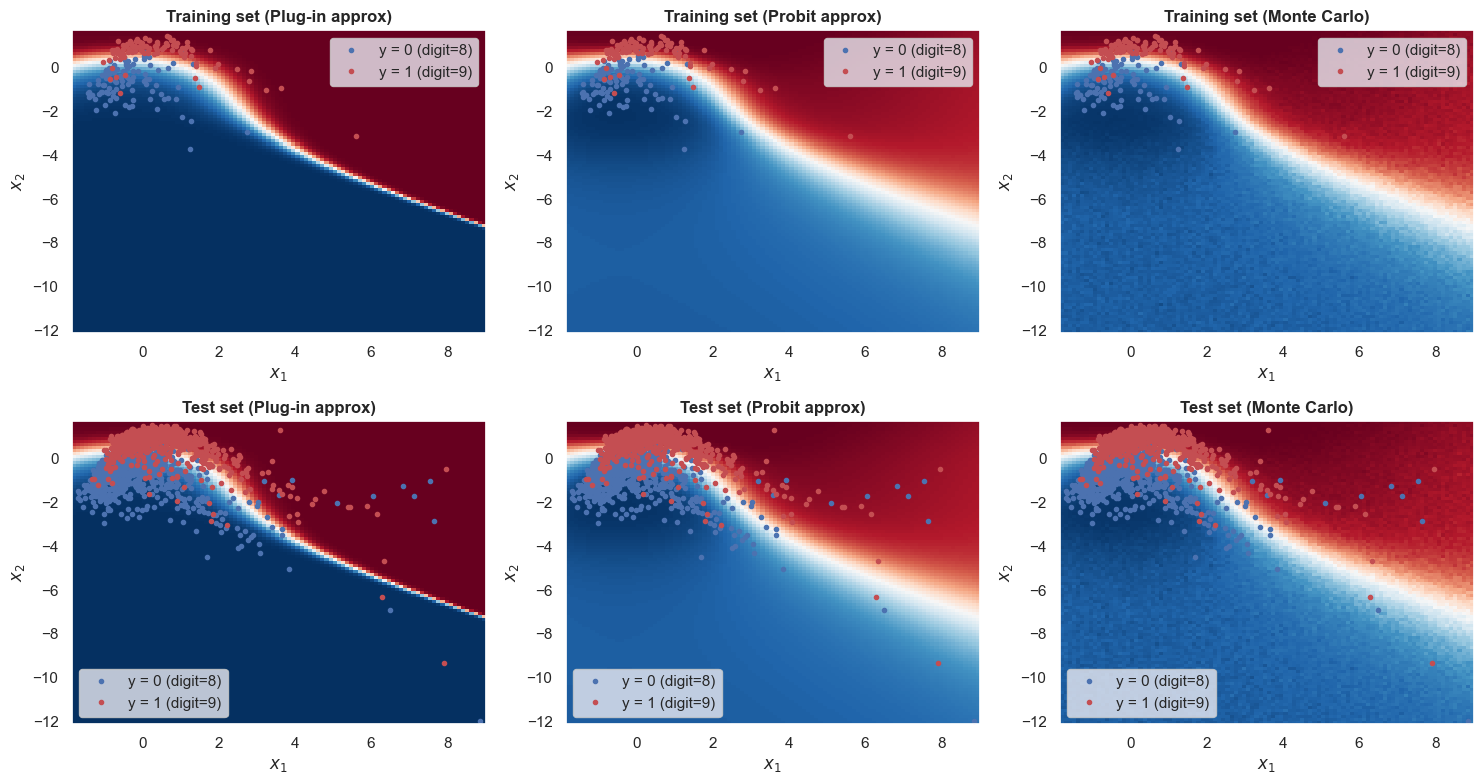

In [32]:
# Probit function: Φ(x) = CDF of standard normal distribution
probit = lambda x: norm_dist.cdf(x)

class PosteriorPredictiveDistribution(object):
    """
    Posterior predictive distribution for Bayesian logistic regression
    
    Computes p(y*=1|x*, y) using different approximation methods:
    1. Plugin approximation: p(y*=1|x*, w_MAP)
    2. Monte Carlo: ∫ p(y*=1|x*, w) p(w|y) dw via sampling
    3. Probit approximation: analytical approximation
    """
    
    def __init__(self, model):
        """
        Initialize with a trained LogisticRegression model
        
        Args:
            model: LogisticRegression object with computed w_MAP
        """
        self.model = model
        self.feature_transformation = model.feature_transformation
        self.laplace = LaplaceApproximation(model)

    def posterior_f(self, xstar_):
        """
        Compute posterior distribution of linear function f* = w^T x*
        
        Args:
            xstar_: array, shape (M, D_original) - test points
            
        Returns:
            m: array, shape (M,) - posterior mean of f*
            v: array, shape (M,) - posterior variance of f*
            
        Equations:
            Given: w ~ N(m_w, S_w) [Laplace approximation]
            Then: f* = w^T x* ~ N(m_f, v_f)
            where:
                m_f = E[f*] = x*^T m_w
                v_f = Var[f*] = x*^T S_w x*
        """
        # Preprocess features (apply transformation and standardization)
        xstar = self.model.preprocess(xstar_)  # Shape: (M, D)
        
        # Posterior mean: E[f*] = x*^T m_w
        m = xstar @ self.laplace.posterior_mean  # Shape: (M,)
        
        # Posterior variance: Var[f*] = x*^T S_w x*
        # Using diagonal only for computational efficiency
        v = jnp.diag(xstar @ self.laplace.posterior_cov @ xstar.T)  # Shape: (M,)
        
        return m, v

    def plugin_approx(self, xstar_):
        """
        Plugin approximation: use MAP estimate directly
        
        Args:
            xstar_: array, shape (M, D_original) - test points
            
        Returns:
            p: array, shape (M,) - predicted probabilities
            
        Equation:
            p(y*=1|x*, y) ≈ p(y*=1|x*, w_MAP) = σ(w_MAP^T x*)
        """
        # Preprocess and predict using MAP estimate
        xstar = self.model.preprocess(xstar_)
        p = model.predict(xstar, model.w_MAP)  # Shape: (M,)

        assert p.shape == (len(xstar_),), f"Expected the shape of the output from the Monte Carlo approximation to be ({len(xstar_)},), but the received shape was {p.shape}"
        return p
    
    def montecarlo(self, xstar, num_samples=1000, seed=0):
        """
        Monte Carlo approximation of posterior predictive
        
        Args:
            xstar: array, shape (M, D_original) - test points
            num_samples: int - number of MC samples
            seed: int - random seed
            
        Returns:
            p: array, shape (M,) - predicted probabilities
            
        Algorithm:
            1. Sample f* ~ N(m_f, v_f)
            2. Compute p = E[σ(f*)] ≈ (1/S) Σ_s σ(f*_s)
        """
        # Get posterior distribution of f*
        m, v = self.posterior_f(xstar)  # m, v shapes: (M,)

        # Generate samples from posterior of f*
        key = random.PRNGKey(seed)
        # Sample: f* = m + sqrt(v) * ε, where ε ~ N(0,1)
        f = m + jnp.sqrt(v) * random.normal(key, shape=(num_samples, len(xstar)))
        # f shape: (num_samples, M)
        
        # Compute Monte Carlo estimate: p ≈ (1/S) Σ_s σ(f*_s)
        p = sigmoid(f).mean(0)  # Average over samples, shape: (M,)

        assert p.shape == (len(xstar),), f"Expected the shape of the output from the Monte Carlo approximation to be ({len(xstar)},), but the received shape was {p.shape}"
        return p

    def probit_approx(self, xstar):
        """
        Probit approximation for posterior predictive
        
        Args:
            xstar: array, shape (M, D_original) - test points
            
        Returns:
            p: array, shape (M,) - predicted probabilities
            
        Equation:
            p(y*=1|x*, y) ≈ Φ(m_f / √(v_f + π/8))
            
        Where:
            - Φ is the probit function (standard normal CDF)
            - m_f, v_f are posterior mean and variance of f*
            - π/8 term approximates sigmoid-probit difference
        """
        # Get posterior distribution of f*
        m, v = self.posterior_f(xstar)  # m, v shapes: (M,)

        # Apply probit approximation
        # The denominator √(π/8 + v) accounts for:
        # 1. Uncertainty in f* (variance v)
        # 2. Sigmoid-probit approximation (π/8 term)
        p = probit(m / jnp.sqrt(8/jnp.pi + v))  # Shape: (M,)

        assert p.shape == (len(xstar),), f"Expected the shape of the output from the Monte Carlo approximation to be ({len(xstar)},), but the received shape was {p.shape}"
        return p
    
# Polynomial feature transformation
def feature_transformation(x, order=1):
    """
    Create polynomial features up to specified order
    
    Args:
        x: array, shape (N, D) - input features
        order: int - maximum polynomial degree
        
    Returns:
        features: array, shape (N, D*(order+1)) - polynomial features
    """
    return jnp.column_stack([x**m for m in range(order+1)])

# Set up model with cubic polynomial features (order=3)
model = LogisticRegression(
    Xtrain, 
    ytrain, 
    feature_transformation=lambda x: feature_transformation(x, 3)
)

# Create posterior predictive distribution object
postpred = PosteriorPredictiveDistribution(model)

# Dictionary of prediction methods for comparison
pred_dict = {   
    'Plug-in approx': postpred.plugin_approx,  # Uses w_MAP directly
    'Probit approx':  postpred.probit_approx,  # Analytical approximation
    'Monte Carlo':    postpred.montecarlo,     # Sampling-based
}

# Create 2D grid for visualization
dim1 = jnp.linspace(Xtest[:, 0].min()-0.1, Xtest[:, 0].max()+0.1, 100)
dim2 = jnp.linspace(Xtest[:, 1].min()-0.1, Xtest[:, 1].max()+0.1, 100)

# Create visualization comparing all three methods
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
    
# Loop through each prediction method
for i, (name, predict_func) in enumerate(pred_dict.items()):
    # Create prediction grid for current method
    predict_grid = Grid2D(dim1, dim2, predict_func)

    # Top row: Training data with predictions
    plot_data(ax[0, i], Xtrain, ytrain, alpha=0.5)
    predict_grid.plot_heatmap(ax[0, i])
    ax[0, i].set_title(f'Training set ({name})', fontweight='bold')
    ax[0, i].set(xlabel='$x_1$', ylabel='$x_2$')
    
    # Bottom row: Test data with predictions
    plot_data(ax[1, i], Xtest, ytest, alpha=0.5)
    predict_grid.plot_heatmap(ax[1, i])
    ax[1, i].set_title(f'Test set ({name})', fontweight='bold')
    ax[1, i].set(xlabel='$x_1$', ylabel='$x_2$')

# Adjust layout
fig.tight_layout()

"""
Comparison of approximation methods:

1. Plugin Approximation:
   - Simplest: p(y*=1) = σ(w_MAP^T x*)
   - Ignores parameter uncertainty
   - Can be overconfident

2. Probit Approximation:
   - Analytical: p(y*=1) ≈ Φ(m/√(v + π/8))
   - Accounts for parameter uncertainty
   - Computationally efficient

3. Monte Carlo:
   - Most accurate: samples from posterior
   - Computationally expensive
   - Gold standard for comparison
"""

_____
**Task 5.2**: Study the maps of the posterior predictive probability above and comment and the qualitative differences.


#### Analysis of Posterior Predictive Probability Maps

Looking at the posterior predictive probability maps, I can observe several qualitative differences between the three approximation methods:

##### 1. Decision Boundary Sharpness

**Plug-in Approximation (Left):**
- Shows very sharp, decisive decision boundaries
- Abrupt transition from blue (low probability) to red (high probability)
- Almost binary classification with minimal uncertainty region

**Probit & Monte Carlo (Middle & Right):**
- Much smoother, gradual transitions between classes
- Wider uncertainty regions (white/light colors) around decision boundaries
- More realistic representation of classification uncertainty

##### 2. Uncertainty Quantification

**Plug-in Approximation:**
- Appears overconfident in predictions
- Even in regions far from training data, it makes strong predictions
- Doesn't account for parameter uncertainty

**Probit & Monte Carlo:**
- Better uncertainty quantification
- Predictions become less confident (more neutral colors) in regions with sparse data
- Account for posterior uncertainty in the weights

##### 3. Extrapolation Behavior

**Plug-in Approximation:**
- Maintains high confidence even in extrapolation regions
- Can lead to overconfident wrong predictions far from training data

**Probit & Monte Carlo:**
- More conservative in extrapolation
- Predictions tend toward 0.5 (neutral) in regions far from observed data
- Better reflects actual model uncertainty

##### 4. Similarity Between Methods

- Probit and Monte Carlo approximations produce very similar results
- Both properly account for parameter uncertainty
- The plugin approximation stands out as distinctly different (and less realistic)

#### Key Insight

The main difference is that the plug-in approximation ignores parameter uncertainty by using only w_MAP, while the Probit and Monte Carlo methods integrate over the posterior distribution of weights. This leads to more calibrated probability estimates that better reflect the true uncertainty in predictions, especially in regions with limited training data.

_______

**Task 5.3**: Compute the training and test accuracy and ELPD for each of the three approximations:

*Hint: the ELPD may evaluate to -infinity for the plug-in approximation for numerical reasons. The problem is that we are first computing the predictive probability and then computing the ELPD. This is problematic when the predicted probabilities become either 0 or 1 to due to numerical underflow/overflow. However, this problem can be avoided by evaluating the ELPDs using the log probabilities instead.*

**Solution**

In [33]:
print(70*'*')
print(f'Method\t\t\tMetric\t\tTraining\tTest')
print(70*'*')
# loop over metrics
for metric_name, metric_fun in metrics.items():
    # loop over methods
    for method_name, predict_func in pred_dict.items():

        # make predictions for both training and test set
        p_train_hat = predict_func(Xtrain)
        p_test_hat = predict_func(Xtest)

        # print
        print(f'{method_name:24s}{metric_name:15s}\t{metric_fun(ytrain, p_train_hat):+3.2f}\t\t{metric_fun(ytest, p_test_hat):+3.2f}')
    print()

**********************************************************************
Method			Metric		Training	Test
**********************************************************************
Plug-in approx          Accuracy       	+0.91		+0.91
Probit approx           Accuracy       	+0.91		+0.91
Monte Carlo             Accuracy       	+0.91		+0.91

Plug-in approx          ELPD           	-0.25		-inf
Probit approx           ELPD           	-0.25		-0.25
Monte Carlo             ELPD           	-0.25		-0.26



**End of solution**

# Part 6:  Insights into the posterior predictive distribution via the probit approximation

Besides being a very and accurate approximation of the posterior predictive distribution, we also use the probit approximation to gain insight into the behaviour of the model. The following task shows that if the posterior uncertainty of the parameters becomes sufficiently, i.e. $v^* = (\mathbf{x}^*)^T  \mathbf{S} \mathbf{x}_*$, then the posterior predictive distribution will be approach $\frac{1}{2}$.


**Task 6.1**: Show that the posterior predictive probability $p(y^*=1|\textbf{y}, \mathbf{x}) \rightarrow 0.5$ as the variance $v^* \rightarrow \infty$.

*Hints: What happens to $\frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}}$ as $v^*$ increases?*

**Solution**

We have that

$$\begin{align*}
\lim_{v^* \rightarrow \infty} \frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}} = 0
\end{align*}$$

Hence, since $\Phi(\cdot)$ is a continuous function, we have that

$$\begin{align*}
\lim_{v^* \rightarrow \infty} \Phi\left(\frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}}\right) = 0.5
\end{align*}
$$



**End of solution**


**Task 6.2**: Show/argue that the plug-in approximation and the probit approximation generate the same **decisions** if we use the decision rule $y^* = \arg\max_{k} p(y^*=k|\textbf{y}, \textbf{x}^*)$.

**Solution**

For binary classification with the decision rule above, the decision boundary for the plugin approximation is given by $\sigma(\mathbf{m}^T \mathbf{x}^*) = 0.5 \iff \mathbf{m}^T \mathbf{x}^* = 0$. Hence, if the inner product $\mathbf{m}^T \mathbf{x}^*$ is positive, we assign $y^* = 1$ and vice versa.

Let's now look at the decision boundary for the probit approximation. We have 

$$\begin{align*}
\Phi\left(\frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}}\right) = 0.5 \iff \frac{m^*}{\sqrt{\frac{8}{\pi} + v^*}} = \frac{\mathbf{m}^T \mathbf{x} ^*}{\sqrt{\frac{8}{\pi} + v^*}} = 0
\end{align*}$$

Now since the denominator is always positive, changing $v^*$ does not change the decision. It changes the probabilties, but not the decision. Hence, if the inner product $\mathbf{m}^T \mathbf{x}^*$ is positive, the probit approximation also assigns $y^* = 1$ and vice versa.

**End of solution**
